In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# gervasio file_path
file_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"


# Temperature

In [2]:
import pandas as pd
import requests

def fetch_hourly_temperature(start_date, end_date, latitude=51.5074, longitude=-0.1278):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m",
        "timezone": "Europe/London"
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": pd.to_datetime(data['hourly']['time']),
        "temperature": data['hourly']['temperature_2m']
    })
    return df

# Download data for the full treatment and pre-treatment periods
df_temp = fetch_hourly_temperature("2023-01-01", "2024-12-31")
df_temp.to_csv("london_hourly_temperature_2023_2024.csv", index=False)


In [3]:
df_temp

,time,temperature
0,2023-01-01 00:00:00,12.1
1,2023-01-01 01:00:00,11.3
2,2023-01-01 02:00:00,12.0
3,2023-01-01 03:00:00,11.1
4,2023-01-01 04:00:00,10.5
...,...,...
17539,2024-12-31 19:00:00,10.7
17540,2024-12-31 20:00:00,10.9
17541,2024-12-31 21:00:00,10.9
17542,2024-12-31 22:00:00,10.8


In [4]:
df_weather = df_temp

#df_weather['Timestamp'] = pd.to_datetime(df_weather['time'])
df_weather['Hour'] = df_weather['time'].dt.hour
df_weather['Date'] = df_weather['time'].dt.date
df_weather.head()

# 1. Filter to 4–7pm only
df_temp_peak = df_weather[df_weather['Hour'].between(16, 18)].copy()

# 2. Daily average for those hours
df_temp_daily = df_temp_peak.groupby(df_temp_peak['time'].dt.date)['temperature'].mean().reset_index()
df_temp_daily.columns = ['Date', 'Temp_4to7_avg']
df_temp_daily.head()

,Date,Temp_4to7_avg
0,2023-01-01,10.400000
1,2023-01-02,4.900000
2,2023-01-03,10.566667
3,2023-01-04,12.066667
4,2023-01-05,11.600000


# Electricity

In [5]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path(r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare")

# ----------------------------- #
#  (1)  Helpers
# ----------------------------- #
def load_half_hour_csv(fname: str) -> pd.DataFrame:
    """Read wide half‑hour file → long panel with datetime."""
    df = (pd.read_csv(DATA_DIR / fname)
            .rename(columns={'Unnamed: 0': 'Time'}))
    df['Time'] = pd.to_datetime(df['Time'])
    return df.melt(id_vars='Time',
                   var_name='ANON_ID',
                   value_name='ELEC_KWH')

def tag_window(df, start, end, treat, post_flag):
    """Restrict to [start,end] & add treatment/post dummies."""
    mask = (df['Time'].between(start, end))
    out  = df.loc[mask].copy()
    out['Treatment'] = treat
    out['Post']      = post_flag
    return out

# ----------------------------- #
#  (2)  Load   PRE  (Feb‑23 → Jan‑24)
# ----------------------------- #
pre_rng   = ('2023-04-01', '2023-12-31 23:59:59')
df_pre_ctl = tag_window(load_half_hour_csv("controlePreConsolide.csv"),
                        *pre_rng, treat=0, post_flag=0)
df_pre_trt = tag_window(load_half_hour_csv("interventionPreConsolide.csv"),
                        *pre_rng, treat=1, post_flag=0)
df_pre = pd.concat([df_pre_ctl, df_pre_trt], ignore_index=True)

# ----------------------------- #
#  (3)  Load   POST  (Apr‑24 → Dec‑24)
# ----------------------------- #
post_rng  = ('2024-04-01', '2024-12-31 23:59:59')
df_post_ctl = tag_window(load_half_hour_csv("controleConsolide.csv"),
                         *post_rng, treat=0, post_flag=1)
df_post_trt = tag_window(load_half_hour_csv("interventionConsolide.csv"),
                         *post_rng, treat=1, post_flag=1)
df_post = pd.concat([df_post_ctl, df_post_trt], ignore_index=True)

# ----------------------------- #
#  (4)  Keep only HHs present in **both** periods
# ----------------------------- #
common_ids  = set(df_pre['ANON_ID']).intersection(df_post['ANON_ID'])
df_all = pd.concat([df_pre, df_post], ignore_index=True)
df_all = df_all[df_all['ANON_ID'].isin(common_ids)].reset_index(drop=True)

# ----------------------------- #
#  (5)  Event‑time month index
# ----------------------------- #
df_all['event_month'] = (
    (df_all['Time'].dt.to_period('M')
      .dt.to_timestamp('M')            # last day of month
      - pd.Timestamp('2024-04-30'))    # 0 = April‑24
      .dt.days // 30                   # rough month diff
)

# ----------------------------- #
#  (6)  4‑7 pm peak mean kWh
# ----------------------------- #
peak = df_all[df_all['Time'].dt.hour.between(16,18)]
peak = (peak
        .groupby(['ANON_ID','event_month','Treatment','Post'], as_index=False)
        .agg(peak_kwh=('ELEC_KWH','mean'))
        .sort_values(['ANON_ID','event_month']))

peak.to_parquet("panel_peak_kwh.parquet")
print(peak.head())


                                             ANON_ID  event_month  Treatment  \
0  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -13          1   
1  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -12          1   
2  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -11          1   
3  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -10          1   
4  0045034694b28ba56978092fc4dd601c58774fd74c30b7...           -9          1   

   Post  peak_kwh  
0     0  0.230200  
1     0  0.148113  
2     0  0.080061  
3     0  0.048425  
4     0  0.025565  


In [6]:
# Step 1: Use your `df_all` (filtered to common ANON_IDs, includes Pre & Post)
df_all['Date'] = df_all['Time'].dt.date
df_all['Hour'] = df_all['Time'].dt.hour

# Step 2: Keep 4–7pm
df_peak_all = df_all[df_all['Hour'].between(16, 18)].copy()

# Step 3: Group by Date & ANON_ID
df_peak_agg = (
    df_peak_all.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(peak_kwh=('ELEC_KWH', 'mean'))
)

# Step 4: Merge with temperature
df_peak_merged = pd.merge(df_peak_agg, df_temp_daily, on='Date', how='left')
df_peak_merged['Month'] = pd.to_datetime(df_peak_merged['Date']).dt.month
df_peak_merged['Year'] = pd.to_datetime(df_peak_merged['Date']).dt.year


# Dynamic Difference-in-Differences (DiD) 

### analysis using the rich panel df_peak_merged, which includes:

Average consumption during 4–7pm (peak_kwh)

Month & year

Treatment group indicator

Post-treatment period indicator

Daily temperature during the same period

In [32]:
socio_df.columns

Index(['ANON_ID', 'Group', 'Post', 'Pre', 'AGE_GROUP', 'INCOME_CATEGORY',
       'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE',
       'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
       'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE',
       'SOCIAL_GRADE', 'TARIFF_GROUP', 'Delta', 'Delta_pct', 'Cluster',
       'AGE_GROUP_num', 'INCOME_CATEGORY_num', 'HOUSEHOLD_OCCUPANCY_num',
       'CHILDREN_AT_HOME_num', 'HOUSEHOLD_SIZE_num', 'NUMBER_OF_BEDROOMS_num',
       'HIGHEST_QUALIFICATION_num', 'HOME_VALUE_num', 'SOCIAL_GRADE_num',
       'CATE'],
      dtype='object')

In [8]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])

# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)


# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)


# ---------------------------
# Dynamic DiD formula:
# ---------------------------
# Base: peak_kwh ~ Treatment + Post + C(Month) + Treatment×Post×C(Month) + Temp
# We interact Post × Treatment × Month (which includes all relevant pairwise interactions)

formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']})

# ---------------------------
# View Summary
# ---------------------------
print(model.summary())

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)


<>:37: SyntaxWarning: invalid escape sequence '\('
<>:37: SyntaxWarning: invalid escape sequence '\('
C:\Users\gerva\AppData\Local\Temp\ipykernel_30912\3886181459.py:37: SyntaxWarning: invalid escape sequence '\('
  dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
C:\Users\gerva\AppData\Local\Temp\ipykernel_30912\3886181459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
C:\Users\gerva\AppData\Local\Temp\ipykernel_30912\3886181459.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     30.10
Date:                Tue, 20 May 2025   Prob (F-statistic):          4.31e-101
Time:                        11:20:57   Log-Likelihood:                 61838.
No. Observations:              345196   AIC:                        -1.236e+05
Df Residuals:                  345167   BIC:                        -1.233e+05
Df Model:                          28                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

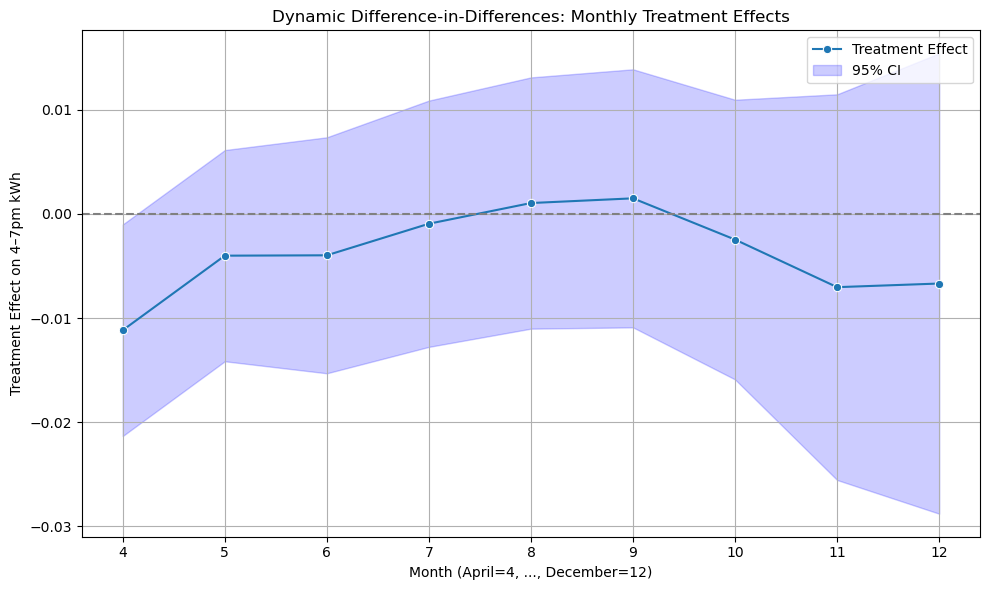

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = dynamic_did.index.str.extract(r'\[(\d+)\]')[0].dropna().astype(int)

# 3. Build dataframe for plotting
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=effect_df, x='Month', y='Effect', marker='o', label='Treatment Effect')
plt.fill_between(effect_df['Month'], effect_df['CI_lower'], effect_df['CI_upper'],
                 alpha=0.2, color='blue', label='95% CI')

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Monthly Treatment Effects")
plt.xlabel("Month (April=4, ..., December=12)")
plt.ylabel("Treatment Effect on 4–7pm kWh")
plt.xticks(ticks=range(4, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# QUANTILE TREATMENT EFFECT


invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('



📈 Estimated Monthly Treatment Effects (Dynamic DiD):
Treatment:Post:C(Month)[10]   -0.001425
Treatment:Post:C(Month)[11]   -0.003224
Treatment:Post:C(Month)[12]   -0.003138
Treatment:Post:C(Month)[4]    -0.008834
Treatment:Post:C(Month)[5]    -0.003324
Treatment:Post:C(Month)[6]    -0.005065
Treatment:Post:C(Month)[7]    -0.002339
Treatment:Post:C(Month)[8]     0.000073
Treatment:Post:C(Month)[9]    -0.000165
dtype: float64

Estimating quantile regression for 0.1th quantile...
QTE estimates for 0.1th quantile:
Treatment:Post:C(Month)[10]   -0.005881
Treatment:Post:C(Month)[11]   -0.000693
Treatment:Post:C(Month)[12]   -0.000392
Treatment:Post:C(Month)[4]    -0.002996
Treatment:Post:C(Month)[5]    -0.002386
Treatment:Post:C(Month)[6]    -0.001803
Treatment:Post:C(Month)[7]    -0.003623
Treatment:Post:C(Month)[8]     0.000562
Treatment:Post:C(Month)[9]    -0.000625
dtype: float64

Estimating quantile regression for 0.25th quantile...
QTE estimates for 0.25th quantile:
Treatment:Post:C(M

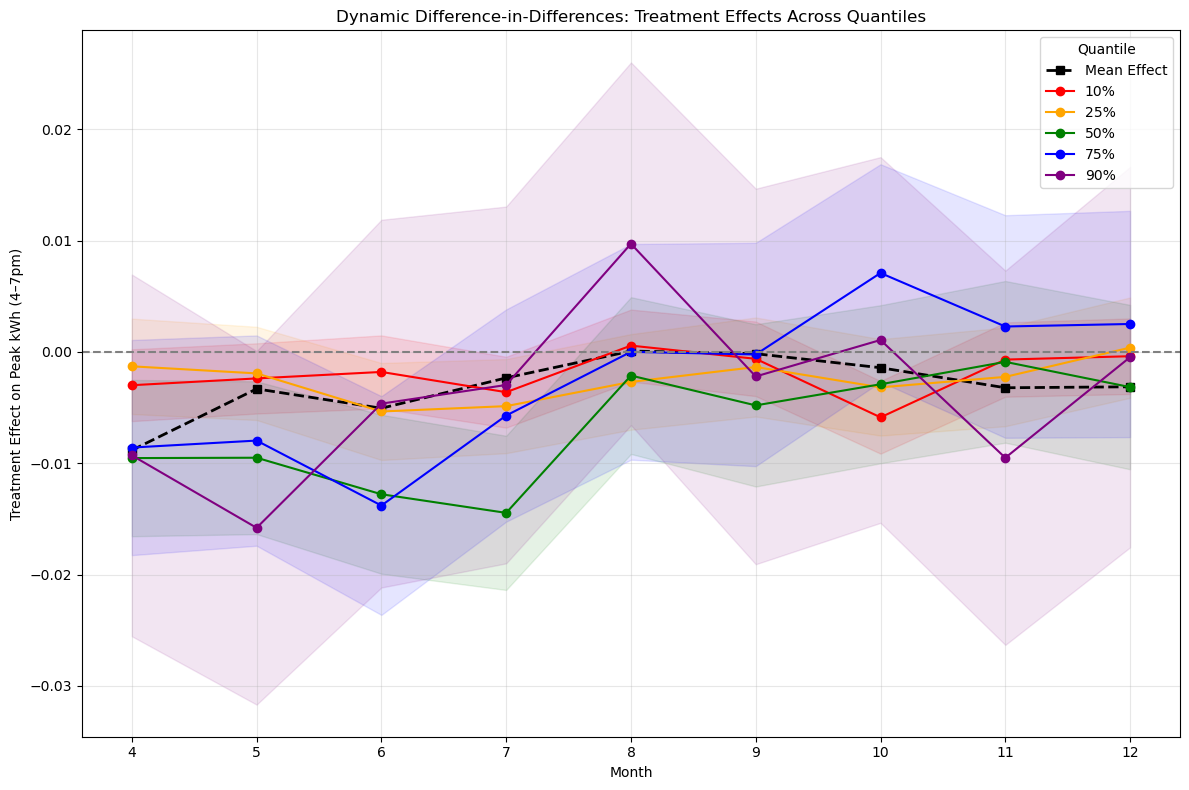

<Figure size 1500x1200 with 0 Axes>

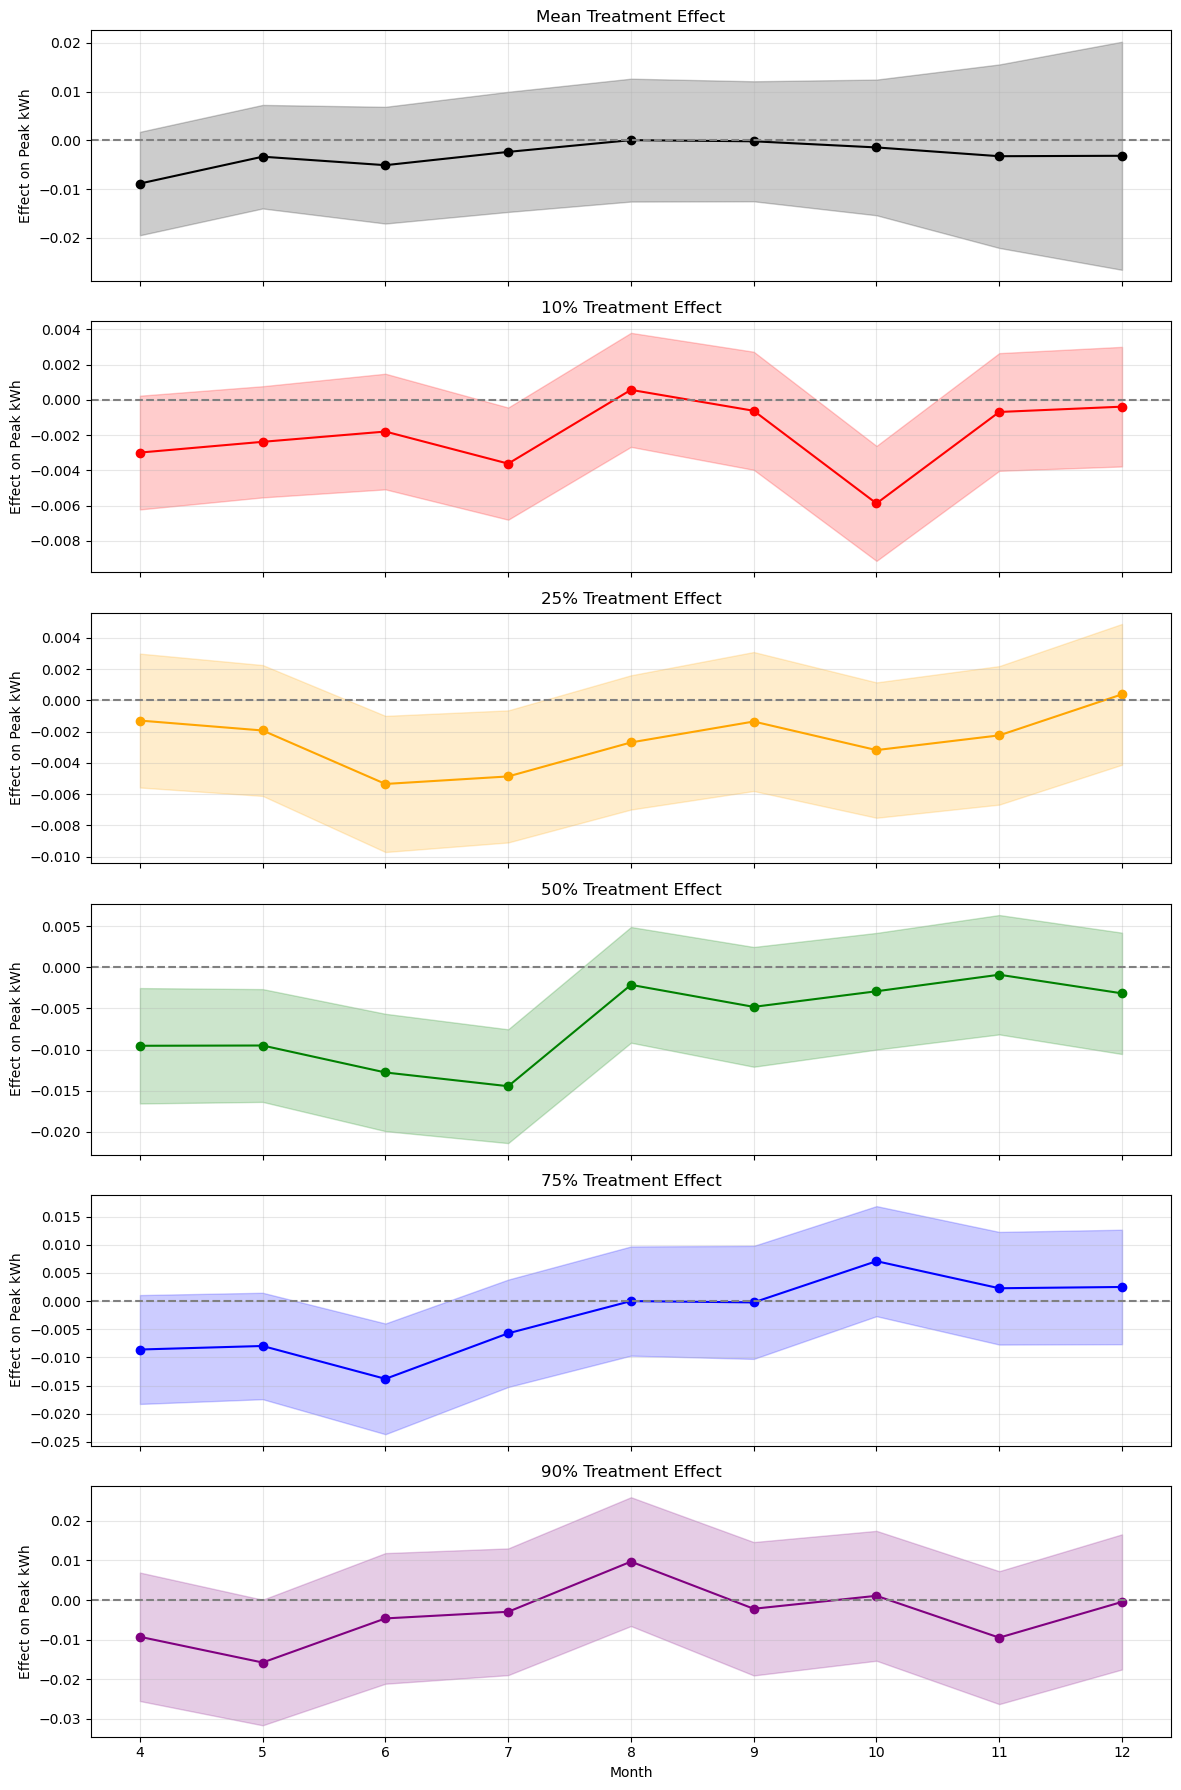

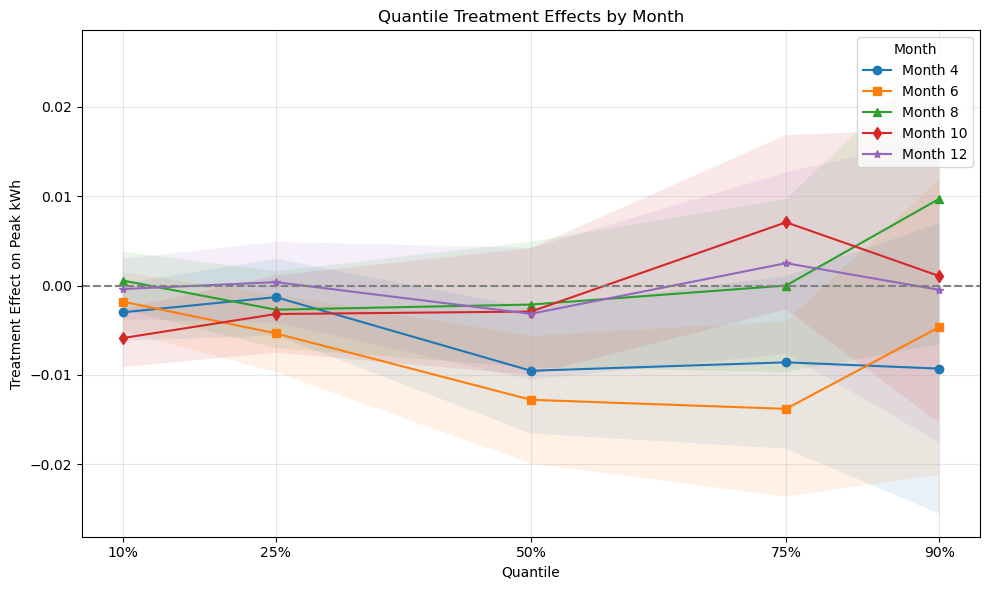

In [74]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns
output_dir = 'quantile_basic_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# Your initial data preparation
# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])
# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# ---------------------------
# Original Dynamic DiD model
# ---------------------------
formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)
# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster', 
                cov_kwds={'groups': df_peak_merged['ANON_ID']})

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)

# ---------------------------
# Quantile Treatment Effects
# ---------------------------
# Define the quantiles to analyze
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
colors = ['red', 'orange', 'green', 'blue', 'purple']  # Colors for different quantiles

# Create a dictionary to store QTE results
qte_results = {}

for q in quantiles:
    print(f"\nEstimating quantile regression for {q}th quantile...")
    
    # Use the same formula structure as the OLS model for consistency
    qr_model = QuantReg.from_formula(formula=formula, data=df_peak_merged)
    qr_fit = qr_model.fit(q=q)
    
    # Extract the Treatment:Post:C(Month) coefficients - same structure as OLS
    q_dynamic_terms = qr_fit.params[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]
    q_dynamic_se = qr_fit.bse[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]
    
    qte_results[q] = {'params': q_dynamic_terms, 'se': q_dynamic_se}
    
    print(f"QTE estimates for {q}th quantile:")
    print(q_dynamic_terms)

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract OLS (mean) Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = [int(m) for m in dynamic_did.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 3. Build dataframe for plotting - Mean effects
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values,
    'Quantile': 'Mean'
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Build dataframes for each quantile
qte_dfs = []
for q in quantiles:
    # Extract parameters and standard errors for this quantile
    q_params = qte_results[q]['params']
    q_se = qte_results[q]['se']
    
    # Extract month numbers using the same method as for mean effects
    q_months = [int(m) for m in q_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]
    
    # Create dataframe for this quantile
    q_df = pd.DataFrame({
        'Month': q_months,
        'Effect': q_params.values,
        'SE': q_se.values,
        'Quantile': f'{int(q*100)}%'
    })
    q_df = q_df.sort_values('Month')
    q_df['CI_lower'] = q_df['Effect'] - 1.96 * q_df['SE']
    q_df['CI_upper'] = q_df['Effect'] + 1.96 * q_df['SE']
    
    qte_dfs.append(q_df)

# Combine all results
all_effects_df = pd.concat([effect_df] + qte_dfs, ignore_index=True)

# ---------------------------
# Create Visualizations
# ---------------------------
# Plot 1: Combined plot with all quantiles
plt.figure(figsize=(12, 8))

# Plot mean effect
mean_data = all_effects_df[all_effects_df['Quantile'] == 'Mean']
plt.plot(mean_data['Month'], mean_data['Effect'], marker='s', color='black', 
         linestyle='--', linewidth=2, label='Mean Effect')

# Plot each quantile
for q, color in zip(quantiles, colors):
    q_label = f'{int(q*100)}%'
    q_data = all_effects_df[all_effects_df['Quantile'] == q_label]
    plt.plot(q_data['Month'], q_data['Effect'], marker='o', color=color, label=q_label)
    plt.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                    alpha=0.1, color=color)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects Across Quantiles")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Quantile")
plt.tight_layout()
plt.show()

# Plot 2: Facet grid with separate panel for each quantile
plt.figure(figsize=(15, 12))
unique_quantiles = all_effects_df['Quantile'].unique()
n_quantiles = len(unique_quantiles)

fig, axes = plt.subplots(nrows=n_quantiles, figsize=(12, 3*n_quantiles), sharex=True)

for i, quant in enumerate(unique_quantiles):
    ax = axes[i]
    q_data = all_effects_df[all_effects_df['Quantile'] == quant]
    
    # Use appropriate color (black for mean, colors for quantiles)
    color = 'black' if quant == 'Mean' else colors[i-1]
    
    ax.plot(q_data['Month'], q_data['Effect'], marker='o', color=color)
    ax.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')
    ax.set_title(f"{quant} Treatment Effect")
    ax.set_ylabel("Effect on Peak kWh")
    ax.grid(True, alpha=0.3)
    
axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_basic_quantile.png'), dpi=300)
plt.show()

# Plot 3: Horizontal comparison of quantile effects for selected months
# Choose a few representative months
selected_months = sorted(list(set(months)))[::2]  # Every other month

plt.figure(figsize=(10, 6))
month_markers = ['o', 's', '^', 'd', '*']

for i, month in enumerate(selected_months):
    # Get data for this month across all quantiles
    month_data = all_effects_df[all_effects_df['Month'] == month]
    # Drop the mean for this plot
    month_data = month_data[month_data['Quantile'] != 'Mean']
    
    # Sort by quantile value for proper ordering on x-axis
    month_data['Quantile_Value'] = month_data['Quantile'].str.rstrip('%').astype(int) / 100
    month_data = month_data.sort_values('Quantile_Value')
    
    # Plot
    plt.plot(month_data['Quantile_Value'], month_data['Effect'], 
             marker=month_markers[i % len(month_markers)], label=f'Month {month}')
    plt.fill_between(month_data['Quantile_Value'], month_data['CI_lower'], 
                     month_data['CI_upper'], alpha=0.1)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Quantile Treatment Effects by Month")
plt.xlabel("Quantile")
plt.ylabel("Treatment Effect on Peak kWh")
plt.xticks([0.1, 0.25, 0.5, 0.75, 0.9], ['10%', '25%', '50%', '75%', '90%'])
plt.grid(True, alpha=0.3)
plt.legend(title="Month")
plt.tight_layout()
plt.show()

In [85]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
# Create a directory to save the plots if it doesn't exist
output_dir = 'quantile_dynamic_effect_plots'
os.makedirs(output_dir, exist_ok=True)
# Your initial data preparation
# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])
# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# ---------------------------
# Original Dynamic DiD model
# ---------------------------
formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)
# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster', 
                cov_kwds={'groups': df_peak_merged['ANON_ID']})

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)

# ---------------------------
# Quantile Treatment Effects
# ---------------------------
# Number of quantiles to analyze (you can change this to any number)
num_quantiles = 9

# Generate evenly spaced quantiles
quantiles = np.linspace(0.1, 0.9, num=num_quantiles)

# Create color map for the different quantiles
cmap = cm.get_cmap('viridis', num_quantiles)
colors = [cmap(i) for i in range(num_quantiles)]

# Create a dictionary to store QTE results
qte_results = {}

for q in quantiles:
    print(f"\nEstimating quantile regression for {q:.2f}th quantile...")
    
    # Use the same formula structure as the OLS model for consistency
    qr_model = QuantReg.from_formula(formula=formula, data=df_peak_merged)
    qr_fit = qr_model.fit(q=q)
    
    # Extract the Treatment:Post:C(Month) coefficients - same structure as OLS
    q_dynamic_terms = qr_fit.params[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]
    q_dynamic_se = qr_fit.bse[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]
    
    qte_results[q] = {'params': q_dynamic_terms, 'se': q_dynamic_se}
    
    print(f"QTE estimates for {q:.2f}th quantile:")
    print(q_dynamic_terms)

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract OLS (mean) Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = [int(m) for m in dynamic_did.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 3. Build dataframe for plotting - Mean effects
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values,
    'Quantile': 'Mean',
    'Quantile_Value': None
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Build dataframes for each quantile
qte_dfs = []
for q in quantiles:
    # Extract parameters and standard errors for this quantile
    q_params = qte_results[q]['params']
    q_se = qte_results[q]['se']
    
    # Extract month numbers using the same method as for mean effects
    q_months = [int(m) for m in q_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]
    
    # Create dataframe for this quantile
    q_df = pd.DataFrame({
        'Month': q_months,
        'Effect': q_params.values,
        'SE': q_se.values,
        'Quantile': f'{int(q*100)}%',
        'Quantile_Value': q
    })
    q_df = q_df.sort_values('Month')
    q_df['CI_lower'] = q_df['Effect'] - 1.96 * q_df['SE']
    q_df['CI_upper'] = q_df['Effect'] + 1.96 * q_df['SE']
    
    qte_dfs.append(q_df)

# Combine all results
all_effects_df = pd.concat([effect_df] + qte_dfs, ignore_index=True)



invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('



📈 Estimated Monthly Treatment Effects (Dynamic DiD):
Treatment:Post:C(Month)[10]   -0.001425
Treatment:Post:C(Month)[11]   -0.003224
Treatment:Post:C(Month)[12]   -0.003138
Treatment:Post:C(Month)[4]    -0.008834
Treatment:Post:C(Month)[5]    -0.003324
Treatment:Post:C(Month)[6]    -0.005065
Treatment:Post:C(Month)[7]    -0.002339
Treatment:Post:C(Month)[8]     0.000073
Treatment:Post:C(Month)[9]    -0.000165
dtype: float64

Estimating quantile regression for 0.10th quantile...


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


QTE estimates for 0.10th quantile:
Treatment:Post:C(Month)[10]   -0.005881
Treatment:Post:C(Month)[11]   -0.000693
Treatment:Post:C(Month)[12]   -0.000392
Treatment:Post:C(Month)[4]    -0.002996
Treatment:Post:C(Month)[5]    -0.002386
Treatment:Post:C(Month)[6]    -0.001803
Treatment:Post:C(Month)[7]    -0.003623
Treatment:Post:C(Month)[8]     0.000562
Treatment:Post:C(Month)[9]    -0.000625
dtype: float64

Estimating quantile regression for 0.20th quantile...
QTE estimates for 0.20th quantile:
Treatment:Post:C(Month)[10]   -0.002809
Treatment:Post:C(Month)[11]   -0.002742
Treatment:Post:C(Month)[12]    0.001733
Treatment:Post:C(Month)[4]    -0.001866
Treatment:Post:C(Month)[5]    -0.001931
Treatment:Post:C(Month)[6]    -0.002738
Treatment:Post:C(Month)[7]    -0.004755
Treatment:Post:C(Month)[8]    -0.004050
Treatment:Post:C(Month)[9]    -0.001628
dtype: float64

Estimating quantile regression for 0.30th quantile...
QTE estimates for 0.30th quantile:
Treatment:Post:C(Month)[10]   -0.00

invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('


KeyboardInterrupt: 

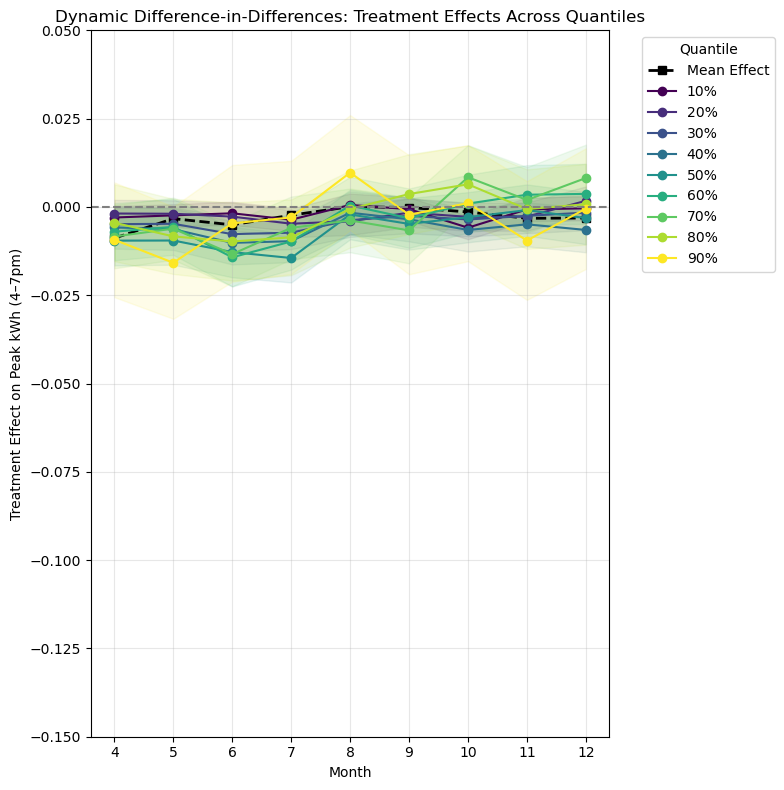

<Figure size 400x2450 with 0 Axes>

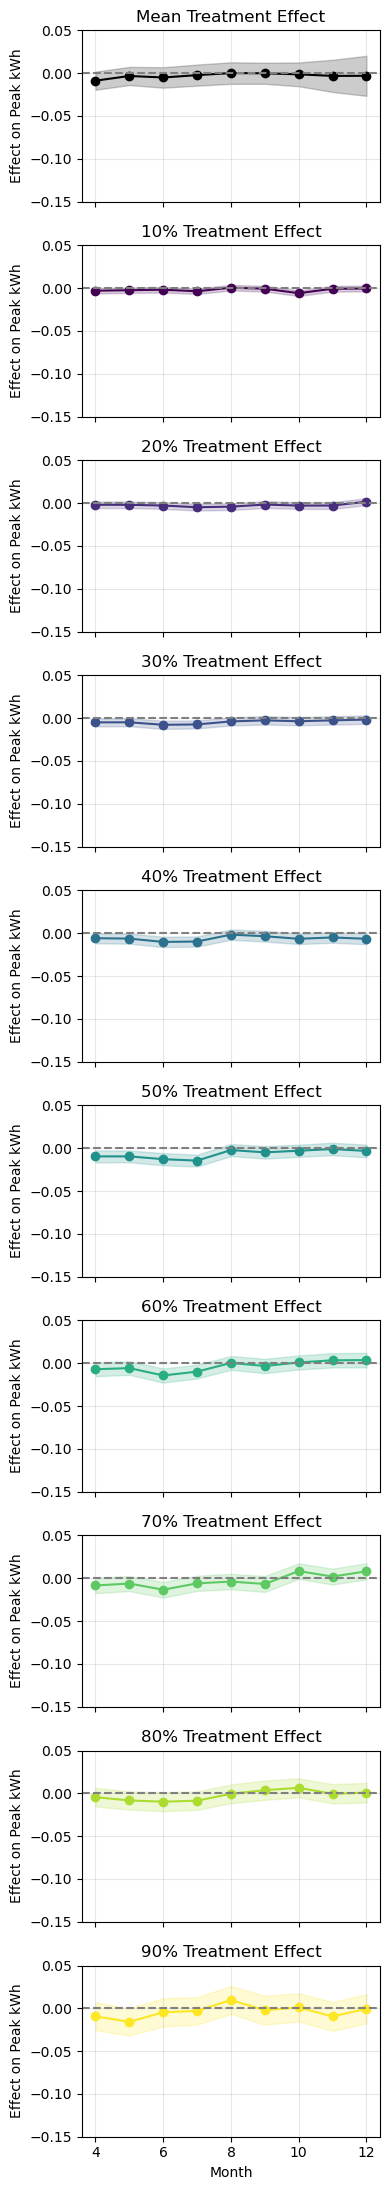

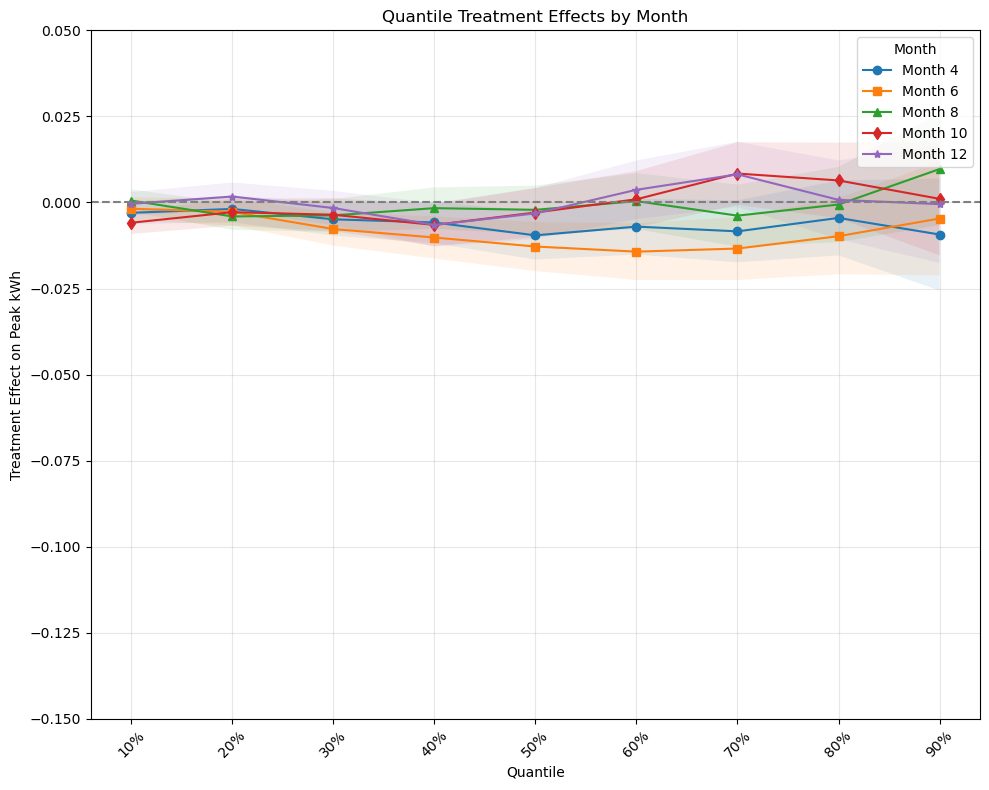

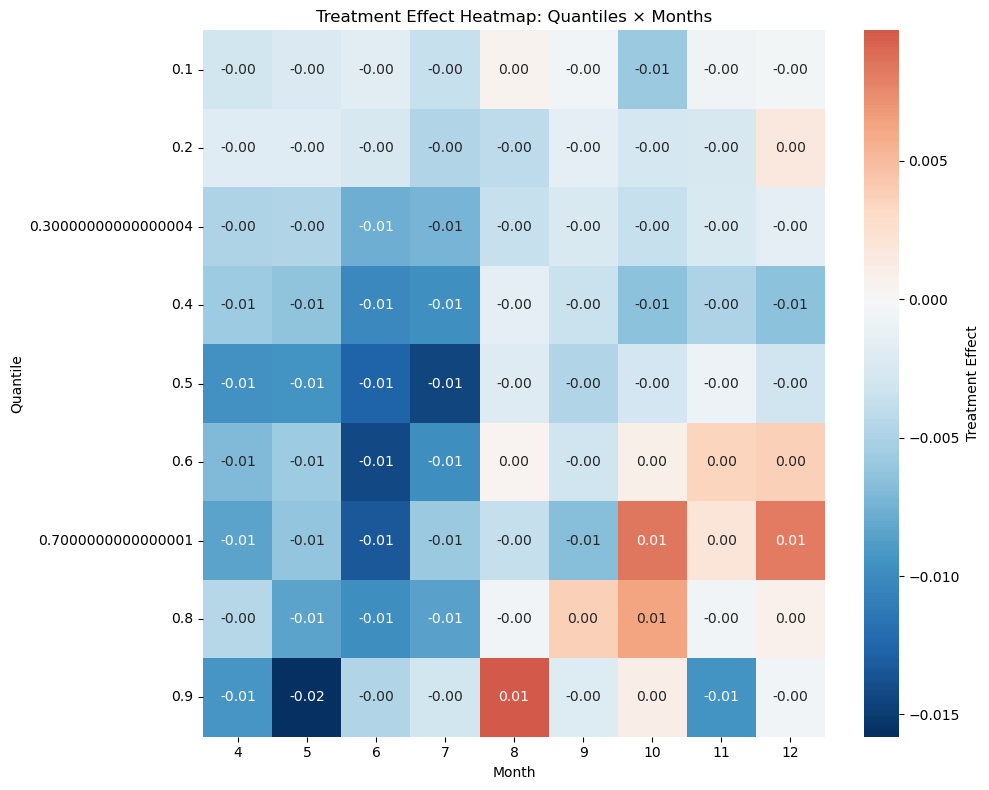

In [86]:
# ---------------------------
# Create Visualizations for quantile plots and export (gotta run previous chunk too)
# ---------------------------
# Plot 1: Combined plot with all quantiles
plt.figure(figsize=(8, 8))

# Plot mean effect
mean_data = all_effects_df[all_effects_df['Quantile'] == 'Mean']
plt.plot(mean_data['Month'], mean_data['Effect'], marker='s', color='black', 
         linestyle='--', linewidth=2, label='Mean Effect')

# Plot each quantile
for i, q in enumerate(quantiles):
    q_label = f'{int(q*100)}%'
    q_data = all_effects_df[all_effects_df['Quantile'] == q_label]
    plt.plot(q_data['Month'], q_data['Effect'], marker='o', color=colors[i], label=q_label)
    plt.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                    alpha=0.1, color=colors[i])

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects Across Quantiles")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Quantile", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylim(-0.15, 0.05)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_treatment_effects_by_months.jpg'), dpi=400)
plt.show()

# Plot 2: Facet grid with separate panel for each quantile
plt.figure(figsize=(4, 2 + 2.5*num_quantiles))  # Adjust height based on number of quantiles
unique_quantiles = ['Mean'] + [f'{int(q*100)}%' for q in quantiles]
n_quantiles = len(unique_quantiles)

fig, axes = plt.subplots(nrows=n_quantiles, figsize=(4, 2 + 2*n_quantiles), sharex=True)

for i, quant in enumerate(unique_quantiles):
    ax = axes[i]
    q_data = all_effects_df[all_effects_df['Quantile'] == quant]
    
    # Use appropriate color (black for mean, colors for quantiles)
    color = 'black' if quant == 'Mean' else colors[i-1]
    
    ax.plot(q_data['Month'], q_data['Effect'], marker='o', color=color)
    ax.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')
    ax.set_title(f"{quant} Treatment Effect")
    ax.set_ylabel("Effect on Peak kWh")
    ax.grid(True, alpha=0.3)
    
    # Set the same y-axis limits for each subplot
    ax.set_ylim(-0.15, 0.05)
    
axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'f_01_treatment_effects_by_months.jpg'), dpi=400)
plt.show()

# Plot 3: Horizontal comparison of quantile effects for selected months
# Choose a few representative months (up to 5 for clarity)
all_months = sorted(list(set(months)))
if len(all_months) <= 5:
    selected_months = all_months
else:
    # Select evenly spaced months
    indices = np.linspace(0, len(all_months)-1, 5).astype(int)
    selected_months = [all_months[i] for i in indices]

plt.figure(figsize=(10, 8))
month_markers = ['o', 's', '^', 'd', '*']

for i, month in enumerate(selected_months):
    # Get data for this month across all quantiles
    month_data = all_effects_df[(all_effects_df['Month'] == month) & 
                               (all_effects_df['Quantile'] != 'Mean')]
    
    # Sort by quantile value for proper ordering on x-axis
    month_data = month_data.sort_values('Quantile_Value')
    
    # Plot
    plt.plot(month_data['Quantile_Value'], month_data['Effect'], 
             marker=month_markers[i % len(month_markers)], label=f'Month {month}')
    plt.fill_between(month_data['Quantile_Value'], month_data['CI_lower'], 
                     month_data['CI_upper'], alpha=0.1)
    plt.ylim(-0.15, 0.05)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Quantile Treatment Effects by Month")
plt.xlabel("Quantile")
plt.ylabel("Treatment Effect on Peak kWh")

# Create nice looking x-tick labels based on actual quantiles
plt.xticks(quantiles, [f'{int(q*100)}%' for q in quantiles], rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title="Month")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '02_treatment_effects_by_quantile.png'), dpi=300)
plt.show()

# Plot 4: Heatmap of treatment effects across months and quantiles
# Pivot the data for the heatmap
heatmap_data = all_effects_df[all_effects_df['Quantile'] != 'Mean'].pivot(
    index='Quantile_Value', columns='Month', values='Effect')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f', 
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Heatmap: Quantiles × Months')
plt.xlabel('Month')
plt.ylabel('Quantile')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '03_Heatmap_combined_treatment_effects_by_quantile.jpg'), dpi=400)
plt.show()

Lets now do a similar approach aiming for socioeconomic features

invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Analyzing income category: 0-9,999
  Estimated treatment effects for 0-9,999 (n=4027):
Treatment:Post:C(Month)[10]   -0.015659
Treatment:Post:C(Month)[11]    0.068472
Treatment:Post:C(Month)[12]    0.080432
Treatment:Post:C(Month)[4]    -0.015767
Treatment:Post:C(Month)[5]    -0.065719
Treatment:Post:C(Month)[6]    -0.030432
Treatment:Post:C(Month)[7]    -0.026564
Treatment:Post:C(Month)[8]     0.002041
Treatment:Post:C(Month)[9]    -0.070920
dtype: float64

Analyzing income category: 10,000-19,999
  Estimated treatment effects for 10,000-19,999 (n=15243):
Treatment:Post:C(Month)[10]   -0.024867
Treatment:Post:C(Month)[11]   -0.065535
Treatment:Post:C(Month)[12]   -0.057784
Treatment:Post:C(Month)[4]    -0.038918
Treatment:Post:C(Month)[5]    -0.047006
Treatment:Post:C(Month)[6]    -0.011140
Treatment:Post:C(Month)[7]    -0.016955
Treatment:Post:C(Month)[8]    -0.003879
Treatment:Post:C(Month)[9]    -0.018827
dtype: float64

Analyzing income category: 20,000-29,999
  Estimated treatme

<Figure size 1500x2450 with 0 Axes>

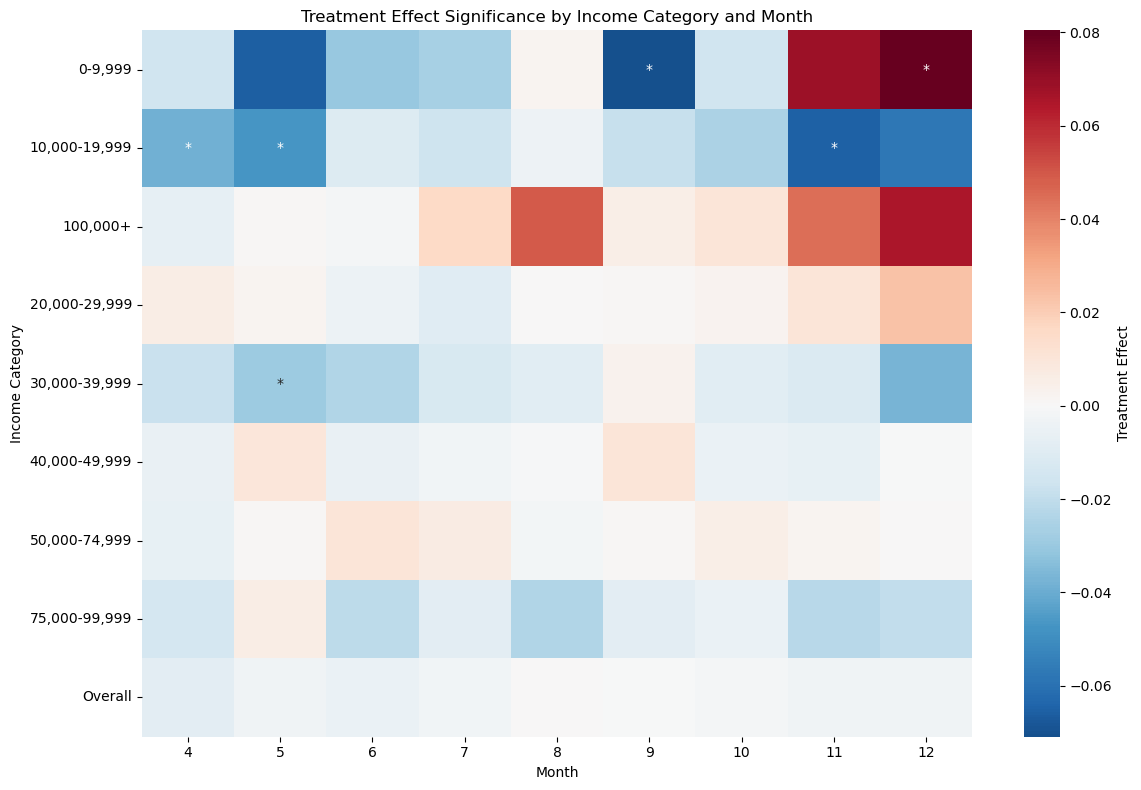

In [75]:
##### import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import os

# Create a directory to save the plots if it doesn't exist
output_dir = 'income_02_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# First check if INCOME_CATEGORY is in the dataset
if 'INCOME_CATEGORY' not in df_peak_merged.columns:
    # Merge with socioeconomic data if needed
    df_peak_merged = pd.merge(
        df_peak_merged, 
        socio_df[['ANON_ID', 'INCOME_CATEGORY']],
        on='ANON_ID',
        how='inner'
    )

# Ensure INCOME_CATEGORY is properly categorized
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
]
df_peak_merged['INCOME_CATEGORY'] = pd.Categorical(
    df_peak_merged['INCOME_CATEGORY'],
    categories=income_category_order,
    ordered=True
)

# Convert necessary columns to appropriate types
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# ---------------------------
# Overall Model (for reference)
# ---------------------------
overall_formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

overall_model = smf.ols(formula=overall_formula, data=df_peak_merged).fit(
    cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']}
)

# Extract overall treatment effects
overall_effects = overall_model.params[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
overall_effects_se = overall_model.bse[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

# ---------------------------
# Income Category Heterogeneity Analysis
# ---------------------------
# Store results for each income category
income_results = {}
income_categories = df_peak_merged['INCOME_CATEGORY'].cat.categories

# Use a colormap for visualizing different income categories
cmap = cm.get_cmap('viridis', len(income_categories))
colors = [cmap(i) for i in range(len(income_categories))]

# Run separate regressions for each income category
for i, income in enumerate(income_categories):
    print(f"\nAnalyzing income category: {income}")
    
    # Subset data for this income category
    income_data = df_peak_merged[df_peak_merged['INCOME_CATEGORY'] == income].copy()
    
    if len(income_data) < 100:  # Skip if sample size is too small
        print(f"  Warning: Small sample size ({len(income_data)} observations). Skipping.")
        continue
        
    # Use the same formula as the overall model
    try:
        income_model = smf.ols(formula=overall_formula, data=income_data).fit(
            cov_type='cluster', cov_kwds={'groups': income_data['ANON_ID']}
        )
        
        # Extract income-specific treatment effects
        income_effects = income_model.params[income_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
        income_effects_se = income_model.bse[income_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
        
        # Store results
        income_results[income] = {
            'params': income_effects,
            'se': income_effects_se,
            'n': len(income_data)
        }
        
        print(f"  Estimated treatment effects for {income} (n={len(income_data)}):")
        print(income_effects)
        
    except Exception as e:
        print(f"  Error analyzing income category {income}: {e}")

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract months from parameter names
months = [int(m) for m in overall_effects.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 2. Build dataframe for the overall effects
overall_df = pd.DataFrame({
    'Month': months,
    'Effect': overall_effects.values,
    'SE': overall_effects_se.values,
    'Category': 'Overall'
})
overall_df = overall_df.sort_values('Month')
overall_df['CI_lower'] = overall_df['Effect'] - 1.96 * overall_df['SE']
overall_df['CI_upper'] = overall_df['Effect'] + 1.96 * overall_df['SE']





<Figure size 800x2450 with 0 Axes>

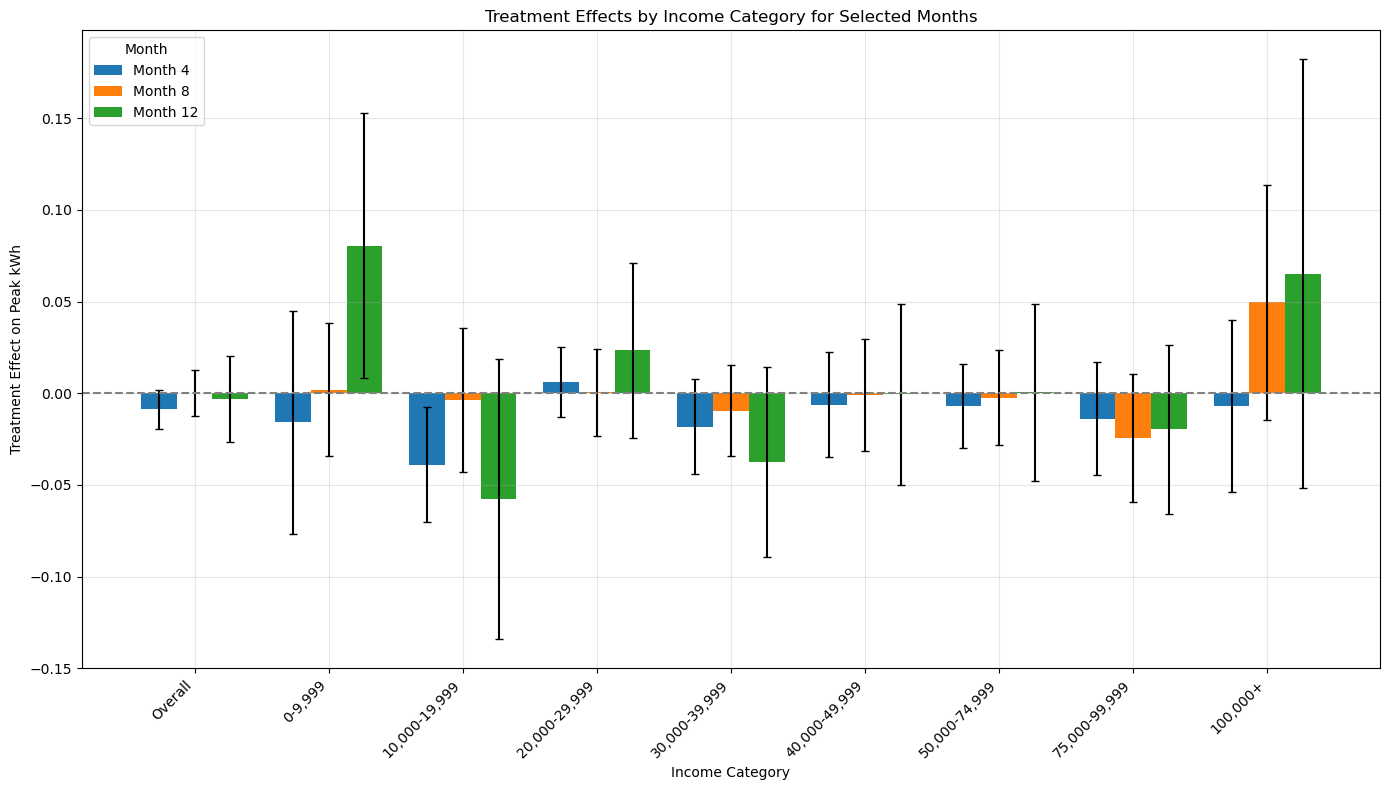

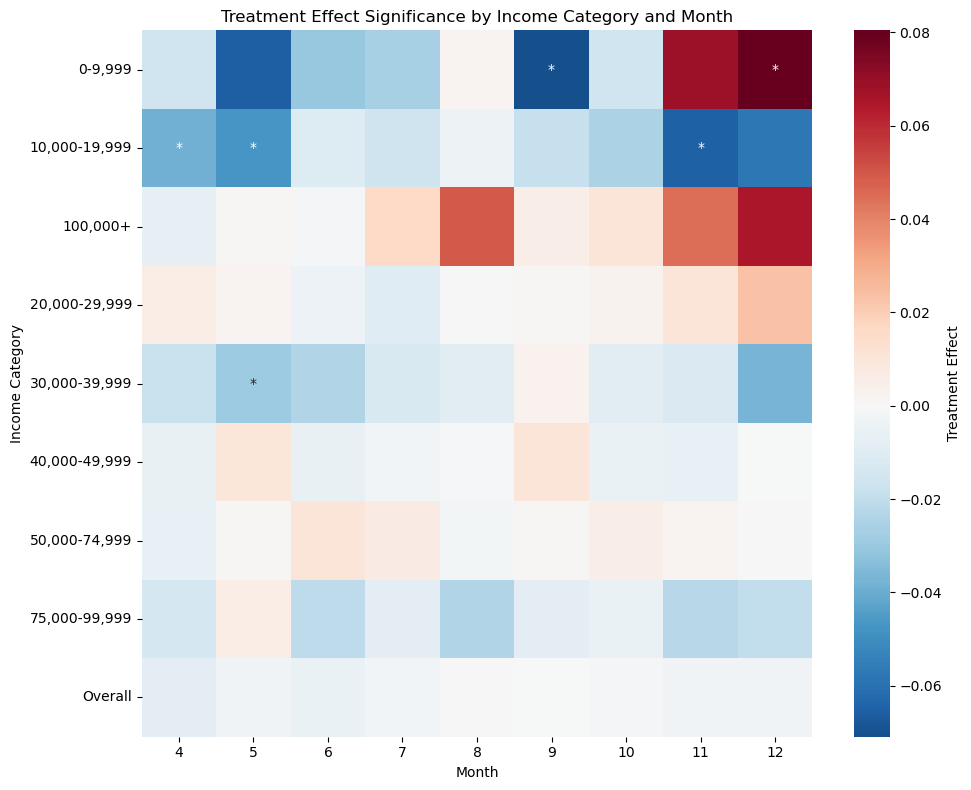

In [83]:
# 3. Build dataframes for each income category
income_dfs = []
for income in income_results:
    # Skip if missing data
    if 'params' not in income_results[income]:
        continue
        
    # Extract parameters and standard errors
    income_params = income_results[income]['params']
    income_se = income_results[income]['se']
    
    # Extract months
    income_months = [int(m) for m in income_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]
    
    # Create dataframe
    income_df = pd.DataFrame({
        'Month': income_months,
        'Effect': income_params.values,
        'SE': income_se.values,
        'Category': income,
        'n': income_results[income]['n']
    })
    income_df = income_df.sort_values('Month')
    income_df['CI_lower'] = income_df['Effect'] - 1.96 * income_df['SE']
    income_df['CI_upper'] = income_df['Effect'] + 1.96 * income_df['SE']
    
    income_dfs.append(income_df)

# Combine all results
all_effects_df = pd.concat([overall_df] + income_dfs, ignore_index=True)
# ---------------------------
# Create Visualizations
# ---------------------------
# Plot 1: Combined plot with all income categories
plt.figure(figsize=(14, 10))

# Plot overall effect
overall_data = all_effects_df[all_effects_df['Category'] == 'Overall']
plt.plot(overall_data['Month'], overall_data['Effect'], marker='s', color='black', 
         linestyle='--', linewidth=2, label='Overall')

# Plot each income category
for i, income in enumerate(income_categories):
    if income not in income_results:
        continue
        
    income_data = all_effects_df[all_effects_df['Category'] == income]
    if len(income_data) == 0:
        continue
        
    plt.plot(income_data['Month'], income_data['Effect'], marker='o', color=colors[i], 
             label=f'{income} (n={income_data["n"].iloc[0]})')
    plt.fill_between(income_data['Month'], income_data['CI_lower'], income_data['CI_upper'],
                    alpha=0.1, color=colors[i])

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects by Income Category")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Income Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# Save the figure instead of showing it
plt.savefig(os.path.join(output_dir, '01_combined_treatment_effects_by_income.jpg'), dpi=400)
plt.close()

# Plot 2: Facet grid with separate panel for each income category
unique_categories = ['Overall'] + [cat for cat in income_categories if cat in income_results]
n_categories = len(unique_categories)

plt.figure(figsize=(8, 2 + 2.5*n_categories))
fig, axes = plt.subplots(nrows=n_categories, figsize=(8, 2 + 2*n_categories), sharex=True)

# Handle the case of only one category
if n_categories == 1:
    axes = [axes]

for i, category in enumerate(unique_categories):
    ax = axes[i]
    cat_data = all_effects_df[all_effects_df['Category'] == category]
    
    # Use appropriate color
    color = 'black' if category == 'Overall' else colors[list(income_categories).index(category)]
    
    ax.plot(cat_data['Month'], cat_data['Effect'], marker='o', color=color)
    ax.fill_between(cat_data['Month'], cat_data['CI_lower'], cat_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')
    
    # Add sample size for income categories
    if category != 'Overall':
        sample_size = cat_data['n'].iloc[0] if 'n' in cat_data else 'N/A'
        ax.set_title(f"{category} (n={sample_size})")
    else:
        ax.set_title("Overall")
        
    ax.set_ylabel("Effect on Peak kWh")
        # Set the same y-axis limits for each subplot
    ax.set_ylim(-0.15, 0.05)
    ax.grid(True, alpha=0.3)
    
axes[-1].set_xlabel("Month")
plt.tight_layout()
# plt.show()
# -----------------
plt.savefig(os.path.join(output_dir, 'final_02_combined_treatment_effects_by_income.jpg'), dpi=400)
plt.close()

# Plot 3: Bar chart comparing treatment effects across income categories for selected months
# Choose a few representative months
all_months = sorted(list(set(months)))
if len(all_months) <= 3:
    selected_months = all_months
else:
    # Select beginning, middle, and end months
    selected_months = [all_months[0], all_months[len(all_months)//2], all_months[-1]]

plt.figure(figsize=(14, 8))

# For each selected month, plot a grouped bar chart
x_positions = np.arange(len(unique_categories))
width = 0.8 / len(selected_months)  # Width of each bar

for i, month in enumerate(selected_months):
    # Offset for this month's group of bars
    offset = (i - len(selected_months)/2 + 0.5) * width
    
    # Collect effects for this month across categories
    effects = []
    ci_lower = []
    ci_upper = []
    
    for category in unique_categories:
        month_cat_data = all_effects_df[(all_effects_df['Month'] == month) & 
                                      (all_effects_df['Category'] == category)]
        
        if len(month_cat_data) > 0:
            effect = month_cat_data['Effect'].iloc[0]
            lower = month_cat_data['CI_lower'].iloc[0]
            upper = month_cat_data['CI_upper'].iloc[0]
        else:
            effect = np.nan
            lower = np.nan
            upper = np.nan
            
        effects.append(effect)
        ci_lower.append(lower)
        ci_upper.append(upper)
    
    # Plot bars for this month
    bars = plt.bar(x_positions + offset, effects, width, label=f'Month {month}')
    
    # Add error bars
    plt.errorbar(x_positions + offset, effects, 
                yerr=[np.array(effects) - np.array(ci_lower), 
                      np.array(ci_upper) - np.array(effects)],
                fmt='none', color='black', capsize=3)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Treatment Effects by Income Category for Selected Months")
plt.xlabel("Income Category")
plt.ylabel("Treatment Effect on Peak kWh")
plt.xticks(x_positions, unique_categories, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title="Month")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(output_dir, '03_combined_treatment_effects_by_income.jpg'), dpi=400)
# plt.close()

# Plot 4: Heatmap of treatment effects across months and income categories
# Pivot the data for the heatmap
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f', 
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Heatmap: Income Categories × Months')
plt.xlabel('Month')
plt.ylabel('Income Category')
plt.tight_layout()
# Save the figure instead of showing it
plt.savefig(os.path.join(output_dir, '04_Heatmap_combined_treatment_effects_by_income.jpg'), dpi=400)
plt.close()

# Plot 5: Display significance patterns
plt.figure(figsize=(10, 8))

# Create a DataFrame with significance markers
sig_data = all_effects_df.copy()
sig_data['Significant'] = np.where(
    (sig_data['CI_lower'] > 0) | (sig_data['CI_upper'] < 0),
    '*',  # Significant effect
    ''    # Not significant
)

# Pivot for heatmap
sig_heatmap = sig_data.pivot(
    index='Category', columns='Month', values='Significant')

# Create a heatmap with significance markers
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=sig_heatmap, fmt='s', 
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Significance by Income Category and Month')
plt.xlabel('Month')
plt.ylabel('Income Category')
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(output_dir, '05_Heatmap_combined_treatment_effects_by_income.jpg'), dpi=400)
#plt.close()

### Now lets try it with counterfactual Cluster

In [77]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

# Create a directory to save the plots
output_dir = 'cluster_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# Assuming df_peak_merged is your main dataset and 'Cluster' is already in it
# If not, merge with the dataframe containing your cluster labels

# Check if Cluster is in the dataset
if 'Cluster' not in df_peak_merged.columns:
    # Merge with socioeconomic data including your cluster variable
    df_peak_merged = pd.merge(
        df_peak_merged, 
        socio_df[['ANON_ID', 'Cluster']],
        on='ANON_ID',
        how='inner'
    )

# Make sure ANON_ID, Month, Treatment, and Post are of appropriate types
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# Make sure Cluster is properly formatted (as string to avoid float precision issues)
df_peak_merged['Cluster'] = df_peak_merged['Cluster'].astype(str)

# Get unique clusters for analysis
cluster_categories = sorted(df_peak_merged['Cluster'].unique())
print(f"Found {len(cluster_categories)} unique clusters: {', '.join(cluster_categories)}")

# ---------------------------
# Overall Model (for reference)
# ---------------------------
overall_formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

overall_model = smf.ols(formula=overall_formula, data=df_peak_merged).fit(
    cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']}
)

# Extract overall treatment effects
overall_effects = overall_model.params[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
overall_effects_se = overall_model.bse[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

# ---------------------------
# Cluster Heterogeneity Analysis
# ---------------------------
# Store results for each cluster
cluster_results = {}

# Create a colormap for clusters (using updated matplotlib syntax)
n_clusters = len(cluster_categories)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Run separate regressions for each cluster
for i, cluster in enumerate(cluster_categories):
    print(f"\nAnalyzing Cluster {cluster}")
    
    # Subset data for this cluster
    cluster_data = df_peak_merged[df_peak_merged['Cluster'] == cluster].copy()
    
    if len(cluster_data) < 100:  # Skip if sample size is too small
        print(f"  Warning: Small sample size ({len(cluster_data)} observations). Skipping.")
        continue
        
    # Use the same formula as the overall model
    try:
        cluster_model = smf.ols(formula=overall_formula, data=cluster_data).fit(
            cov_type='cluster', cov_kwds={'groups': cluster_data['ANON_ID']}
        )
        
        # Extract cluster-specific treatment effects
        cluster_effects = cluster_model.params[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
        cluster_effects_se = cluster_model.bse[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
        
        # Store results
        cluster_results[cluster] = {
            'params': cluster_effects,
            'se': cluster_effects_se,
            'n': len(cluster_data)
        }
        
        print(f"  Estimated treatment effects for Cluster {cluster} (n={len(cluster_data)}):")
        print(cluster_effects)
        
    except Exception as e:
        print(f"  Error analyzing Cluster {cluster}: {e}")

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract months from parameter names
months = [int(m) for m in overall_effects.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 2. Build dataframe for the overall effects
overall_df = pd.DataFrame({
    'Month': months,
    'Effect': overall_effects.values,
    'SE': overall_effects_se.values,
    'Category': 'Overall'
})
overall_df = overall_df.sort_values('Month')
overall_df['CI_lower'] = overall_df['Effect'] - 1.96 * overall_df['SE']
overall_df['CI_upper'] = overall_df['Effect'] + 1.96 * overall_df['SE']

# 3. Build dataframes for each cluster
cluster_dfs = []
for cluster in cluster_results:
    # Extract parameters and standard errors
    cluster_params = cluster_results[cluster]['params']
    cluster_se = cluster_results[cluster]['se']
    
    # Extract months
    cluster_months = [int(m) for m in cluster_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]
    
    # Create dataframe - use exact cluster string for category
    cluster_df = pd.DataFrame({
        'Month': cluster_months,
        'Effect': cluster_params.values,
        'SE': cluster_se.values,
        'Category': f'Cluster {cluster}',
        'n': cluster_results[cluster]['n'],
        'ClusterID': cluster  # Store original cluster ID for easier matching
    })
    cluster_df = cluster_df.sort_values('Month')
    cluster_df['CI_lower'] = cluster_df['Effect'] - 1.96 * cluster_df['SE']
    cluster_df['CI_upper'] = cluster_df['Effect'] + 1.96 * cluster_df['SE']
    
    cluster_dfs.append(cluster_df)

# Combine all results
all_effects_df = pd.concat([overall_df] + cluster_dfs, ignore_index=True)

# Create a mapping from category names to colors for consistent coloring
category_color_map = {'Overall': 'black'}
for i, cluster in enumerate(cluster_categories):
    category_color_map[f'Cluster {cluster}'] = colors[i]

# ---------------------------
# Create Visualizations
# ---------------------------
# Plot 1: Combined plot with all clusters
plt.figure(figsize=(10, 8))

# Plot overall effect
overall_data = all_effects_df[all_effects_df['Category'] == 'Overall']
plt.plot(overall_data['Month'], overall_data['Effect'], marker='s', color='black', 
         linestyle='--', linewidth=2, label='Overall')

# Plot each cluster
for i, cluster in enumerate(cluster_categories):
    category_name = f'Cluster {cluster}'
    if category_name not in all_effects_df['Category'].values:
        continue
        
    cluster_data = all_effects_df[all_effects_df['Category'] == category_name]
    plt.plot(cluster_data['Month'], cluster_data['Effect'], marker='o', color=colors[i], 
             label=f'Cluster {cluster} (n={cluster_data["n"].iloc[0]})')
    plt.fill_between(cluster_data['Month'], cluster_data['CI_lower'], cluster_data['CI_upper'],
                    alpha=0.1, color=colors[i])

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects by Cluster")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-0.15, 0.06)  # Set consistent y-axis limits - adjusted for your data
plt.tight_layout()
# Save the figure
plt.savefig(os.path.join(output_dir, '01_combined_treatment_effects_by_cluster.jpg'), dpi=400)
plt.close()

# Plot 2: Facet grid with separate panel for each cluster
unique_categories = ['Overall'] + [f'Cluster {c}' for c in cluster_categories if f'Cluster {c}' in all_effects_df['Category'].values]
n_categories = len(unique_categories)

fig, axes = plt.subplots(nrows=n_categories, figsize=(10, 2 + 2*n_categories), sharex=True)

# Handle the case of only one category
if n_categories == 1:
    axes = [axes]

for i, category in enumerate(unique_categories):
    ax = axes[i]
    cat_data = all_effects_df[all_effects_df['Category'] == category]
    
    # Use color from our mapping
    color = category_color_map[category]
    
    ax.plot(cat_data['Month'], cat_data['Effect'], marker='o', color=color)
    ax.fill_between(cat_data['Month'], cat_data['CI_lower'], cat_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')
    
    # Add sample size for clusters
    if category != 'Overall':
        sample_size = cat_data['n'].iloc[0] if 'n' in cat_data.columns else 'N/A'
        ax.set_title(f"{category} (n={sample_size})")
    else:
        ax.set_title("Overall")
        
    ax.set_ylabel("Effect on Peak kWh")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.15, 0.06)  # Set consistent y-axis limits - adjusted
    
axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '02_facet_grid_treatment_effects.jpg'), dpi=400)
plt.close()

# Plot 3: Bar chart comparing treatment effects across clusters for selected months
# Choose a few representative months
all_months = sorted(list(set(months)))
if len(all_months) <= 3:
    selected_months = all_months
else:
    # Select beginning, middle, and end months
    selected_months = [all_months[0], all_months[len(all_months)//2], all_months[-1]]

plt.figure(figsize=(10, 8))

# For each selected month, plot a grouped bar chart
x_positions = np.arange(len(unique_categories))
width = 0.8 / len(selected_months)  # Width of each bar

for i, month in enumerate(selected_months):
    # Offset for this month's group of bars
    offset = (i - len(selected_months)/2 + 0.5) * width
    
    # Collect effects for this month across categories
    effects = []
    ci_lower = []
    ci_upper = []
    
    for category in unique_categories:
        month_cat_data = all_effects_df[(all_effects_df['Month'] == month) & 
                                      (all_effects_df['Category'] == category)]
        
        if len(month_cat_data) > 0:
            effect = month_cat_data['Effect'].iloc[0]
            lower = month_cat_data['CI_lower'].iloc[0]
            upper = month_cat_data['CI_upper'].iloc[0]
        else:
            effect = np.nan
            lower = np.nan
            upper = np.nan
            
        effects.append(effect)
        ci_lower.append(lower)
        ci_upper.append(upper)
    
    # Plot bars for this month
    bars = plt.bar(x_positions + offset, effects, width, label=f'Month {month}')
    
    # Add error bars
    plt.errorbar(x_positions + offset, effects, 
                yerr=[np.array(effects) - np.array(ci_lower), 
                      np.array(ci_upper) - np.array(effects)],
                fmt='none', color='black', capsize=3)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Treatment Effects by Cluster for Selected Months")
plt.xlabel("Cluster")
plt.ylabel("Treatment Effect on Peak kWh")
plt.xticks(x_positions, unique_categories, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title="Month")
plt.ylim(-0.15, 0.06)  # Set consistent y-axis limits - adjusted
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '03_bar_chart_selected_months.jpg'), dpi=400)
plt.close()

# Plot 4: Heatmap of treatment effects across months and clusters
# Pivot the data for the heatmap
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.3f', 
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Heatmap: Clusters × Months')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '04_heatmap_treatment_effects.jpg'), dpi=400)
plt.close()

# Plot 5: Display significance patterns
plt.figure(figsize=(10, 8))

# Create a DataFrame with significance markers
sig_data = all_effects_df.copy()
sig_data['Significant'] = np.where(
    (sig_data['CI_lower'] > 0) | (sig_data['CI_upper'] < 0),
    '*',  # Significant effect
    ''    # Not significant
)

# Pivot for heatmap
sig_heatmap = sig_data.pivot(
    index='Category', columns='Month', values='Significant')

# Create a heatmap with significance markers
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=sig_heatmap, fmt='s', 
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Significance by Cluster and Month')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '05_significance_heatmap.jpg'), dpi=400)
plt.close()

# Plot 6: Cluster distribution visualization
plt.figure(figsize=(8, 6))
cluster_counts = df_peak_merged['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.title('Distribution of Observations Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '06_cluster_distribution.jpg'), dpi=400)
plt.close()

# Plot 7: Treatment assignment by cluster
plt.figure(figsize=(8, 6))
treatment_by_cluster = pd.crosstab(
    df_peak_merged['Cluster'], 
    df_peak_merged['Treatment'],
    normalize='index'
) * 100  # Convert to percentage

treatment_by_cluster.plot(kind='bar', stacked=True)
plt.title('Treatment Assignment by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(['Control', 'Treatment'])
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '07_treatment_assignment_by_cluster.jpg'), dpi=400)
plt.close()

print(f"All plots saved to the '{output_dir}' directory in both PNG and JPG formats.")

invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('
invalid escape sequence '\('


Found 7 unique clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0

Analyzing Cluster 0.0
  Estimated treatment effects for Cluster 0.0 (n=6046):
Treatment:Post:C(Month)[10]   -0.118633
Treatment:Post:C(Month)[11]   -0.017536
Treatment:Post:C(Month)[12]    0.019453
Treatment:Post:C(Month)[4]    -0.062868
Treatment:Post:C(Month)[5]    -0.028990
Treatment:Post:C(Month)[6]    -0.012381
Treatment:Post:C(Month)[7]    -0.036090
Treatment:Post:C(Month)[8]    -0.012069
Treatment:Post:C(Month)[9]    -0.023428
dtype: float64

Analyzing Cluster 1.0
  Estimated treatment effects for Cluster 1.0 (n=26823):
Treatment:Post:C(Month)[10]   -0.041301
Treatment:Post:C(Month)[11]   -0.065136
Treatment:Post:C(Month)[12]   -0.023075
Treatment:Post:C(Month)[4]    -0.017586
Treatment:Post:C(Month)[5]     0.000119
Treatment:Post:C(Month)[6]    -0.006833
Treatment:Post:C(Month)[7]    -0.004574
Treatment:Post:C(Month)[8]     0.006678
Treatment:Post:C(Month)[9]    -0.039274
dtype: float64

Analyzing Cluster 2.0
  Estimat

<Figure size 800x600 with 0 Axes>

In [ ]:
sociodf

# Bring Heterogeneous Effects

In [10]:
# Step 0.2 (unchanged)
import pandas as pd
import os

df_merged_with_clusters = pd.read_csv('ANON_ID_w_socio_and_clusters.csv')
socio_df = df_merged_with_clusters

# Drop rows where any feature is missing (NaN)
socio_df.dropna(inplace=True)

# Remove 'Unknown'
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
     'HOME_VALUE'
]

features = [
    'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]
mask_no_unknown = (socio_df[features] != 'Unknown').all(axis=1)
socio_df = socio_df[mask_no_unknown].copy()

print(f"Socio-economic data shape after cleaning: {socio_df.shape}")

# Convert columns with a logical order into ordered categories
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
] # ordinal
household_occupancy_order = ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household']
children_at_home_order = ['0', '1', '2+'] # ordinal
household_size_order = ['1', '2', '3-4', '5+'] # ordinal
number_of_bedrooms_order = ['1', '2', '3', '4', '5+'] # ordinal
highest_qualification_order = [
    'GCSE Equivalent', 'A Level Equivalent', 
    'Secondary Education or Less', 'University Degree or Higher'
] # ordinal
home_value_order = ['0-100k', '100-150k', '150-250k', '250-500k', '500k+'] # ordinal
social_grade_order = ['Social grade A', 'Social grade B', 'Social grade C1', 'Social grade C2', 'Social grade D'] # ordinal 

feature_orders = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order,
    'HOUSEHOLD_OCCUPANCY': household_occupancy_order,
    'CHILDREN_AT_HOME': children_at_home_order,
    'HOUSEHOLD_SIZE': household_size_order,
    'NUMBER_OF_BEDROOMS': number_of_bedrooms_order,
    'HIGHEST_QUALIFICATION': highest_qualification_order,
    'HOME_VALUE': home_value_order,
    'SOCIAL_GRADE': social_grade_order
}
for col, cat_order in feature_orders.items():
    if col in socio_df.columns:
        socio_df[col] = pd.Categorical(socio_df[col], categories=cat_order, ordered=True)


Socio-economic data shape after cleaning: (614, 21)


In [11]:
# Convert ordered categories into numerical codes
for col in feature_orders:
    if col in socio_df.columns:
        socio_df[f"{col}_num"] = socio_df[col].cat.codes

print(socio_df.shape)

socio_df.head()
socio_df['Group'] = socio_df['Group'].map({'Intervention': 1, 'Control': 0})
# Merge numeric socioeconomic data into main df
df_model = socio_df

# Only map if values are still strings
if df_model['Group'].dtype == 'object':
    df_model['Group'] = df_model['Group'].map({'Intervention': 1, 'Control': 0})
    print("Group column successfully mapped to binary values.")
else:
    print("Group column is already numeric — no mapping applied.")

# Optional: confirm result
print("Unique values in Group column:", df_model['Group'].unique())


(614, 30)
Group column is already numeric — no mapping applied.
Unique values in Group column: [0 1]


In [12]:
from statsmodels.formula.api import ols

model = ols("Delta ~ Group * C(Cluster)", data=df_merged_with_clusters).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.065
Date:                Tue, 20 May 2025   Prob (F-statistic):              0.387
Time:                        11:20:57   Log-Likelihood:                 863.18
No. Observations:                 614   AIC:                            -1698.
Df Residuals:                     600   BIC:                            -1636.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

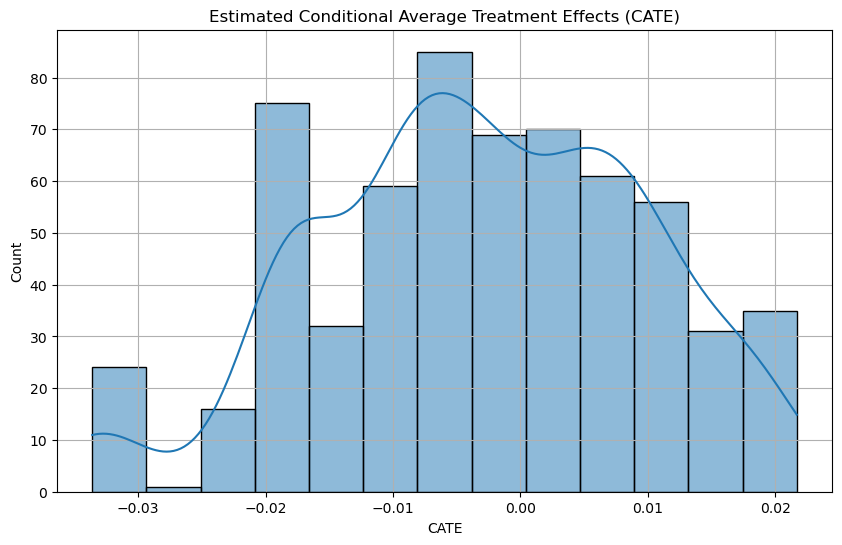

-0.0031706657649661547


In [13]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

 

features_causal = {
    'CHILDREN_AT_HOME': children_at_home_order,
    'INCOME_CATEGORY': income_category_order
}
# Inputs
# Define X, T, and Y
X_cols = [f"{col}_num" for col in features_causal] + ['Cluster']  # add 'Cluster' or any other numeric variable
X = df_model[X_cols]
T = df_model['Group']  # 1 = treated, 0 = control
Y = df_model['Delta']  # outcome variable


model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

cf = CausalForestDML(model_y=model_y, model_t=model_t, random_state=42)
cf.fit(Y, T, X=X)
avgTE = cf.ate(X)


# Estimate Conditional Average Treatment Effects
df_model['CATE'] = cf.effect(X)

# Optional: Visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_model['CATE'], kde=True)
plt.title("Estimated Conditional Average Treatment Effects (CATE)")
plt.xlabel("CATE")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print(avgTE)

In [14]:
df_cate = df_model.groupby('Cluster')['CATE'].mean().sort_values()
print(df_cate)
# When there are many features, 

Cluster
5.0   -0.010547
1.0   -0.010243
0.0   -0.006489
2.0   -0.002660
6.0   -0.001551
4.0    0.000286
3.0    0.002169
Name: CATE, dtype: float64


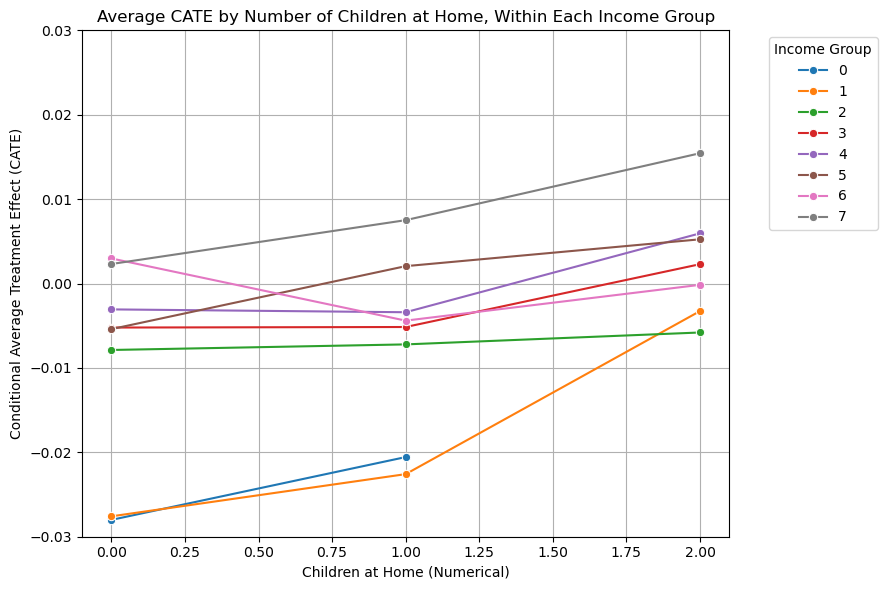

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by Income and Children count, compute average CATE
df_cate_by_income = (
    df_model
    .groupby(['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num'])['CATE']
    .mean()
    .reset_index()
)

# Plot using Seaborn
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=df_cate_by_income,
    x='CHILDREN_AT_HOME_num',
    y='CATE',
    hue='INCOME_CATEGORY_num',
    marker='o',
    palette='tab10'
)

# Labels and styling
plt.title("Average CATE by Number of Children at Home, Within Each Income Group")
plt.xlabel("Children at Home (Numerical)")
plt.ylabel("Conditional Average Treatment Effect (CATE)")
plt.grid(True)
plt.legend(title="Income Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.ylim(-0.03,0.03)
plt.show()


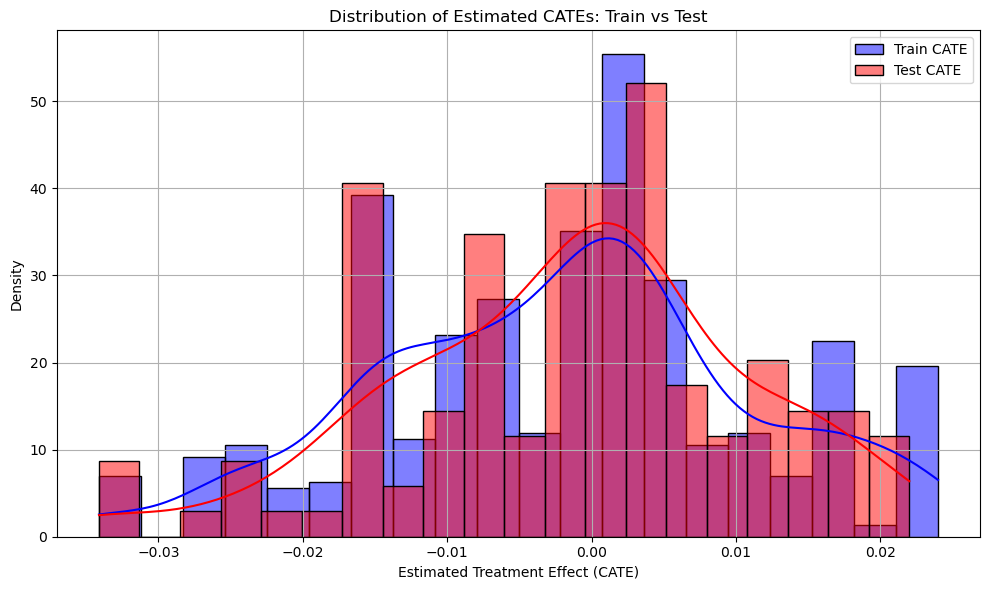

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define Variables
features = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']

import pandas as pd

# Step 1: Create dummies from the 'Cluster' column
cluster_dummies = pd.get_dummies(df_model['Cluster'], prefix='Cluster', drop_first=False)

# Step 2: Concatenate dummies to df_model
df_model_with_dummies = pd.concat([df_model, cluster_dummies], axis=1)

# Step 3: Select only the cluster dummy columns as features
cluster_dummy_features = cluster_dummies.columns.tolist()  # e.g., ['Cluster_0', 'Cluster_1', ...]
X = df_model_with_dummies[features]
T = df_model_with_dummies['Group']
Y = df_model_with_dummies['Delta']




# 2. Train/Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

model_y = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)

# model T -> uses features to predict the treatment T
model_t = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)


cf = CausalForestDML(
    model_y=model_y,           # see above
    model_t=model_t,           # see above 
    n_estimators=500,          # Number of trees in the forest
    max_depth=10,              # Max depth of each tree
    min_samples_leaf=5,        # Min samples required in a leaf
    max_samples=0.5,           # Fraction of samples to use for each tree
    discrete_treatment=True,   # Binary treatment
    cv=5,                      # 5-fold cross-fitting
    honest=True,               # 'honest' splitting separates data used for node splitting and treatment effect measurement
    criterion='mse',           # splitting criterion maximises heterogeneity score; could also use 'mse'
    random_state=1
)

cf.fit(Y_train, T_train, X=X_train)
# 4. Estimate CATE on both sets
cate_train = cf.effect(X_train)
cate_test = cf.effect(X_test)

# 5. Plot Distributions
plt.figure(figsize=(10, 6))
sns.histplot(cate_train, color='blue', label='Train CATE', kde=True, stat="density",bins=20)
sns.histplot(cate_test, color='red', label='Test CATE', kde=True, stat="density",bins=20)
plt.title("Distribution of Estimated CATEs: Train vs Test")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim()
plt.show()

# 6. Add to dataframe for downstream use (optional)
df_model_train = X_train.copy()
df_model_test = X_test.copy()
df_model_train['CATE'] = cate_train
df_model_test['CATE'] = cate_test


# achieved X MSE (treatment effect) using CF only socio features
# now i added this clusters, do we improve?


   Cluster  Average_CATE
0      0.0     -0.003388
1      1.0     -0.007009
2      2.0     -0.000682
3      3.0      0.005752
4      4.0      0.002764
5      5.0     -0.016369
6      6.0      0.000271




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



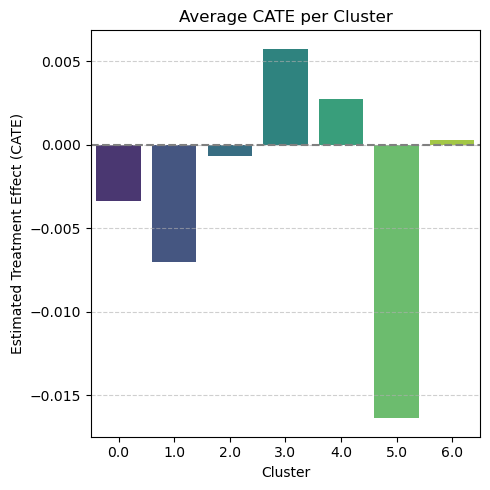

In [17]:
# 7. Add Cluster labels back (we need these for grouping)
df_model_train['Cluster'] = df_model.loc[X_train.index, 'Cluster'].values
df_model_test['Cluster'] = df_model.loc[X_test.index, 'Cluster'].values

# 8. Combine and compute average CATE per cluster
df_model_all = pd.concat([df_model_train, df_model_test], ignore_index=True)

# 9. Compute average CATE by cluster
cluster_avg_cate = df_model_all.groupby('Cluster')['CATE'].mean().reset_index()
cluster_avg_cate.columns = ['Cluster', 'Average_CATE']
print(cluster_avg_cate)

# Optional: Plot
plt.figure(figsize=(5, 5))
sns.barplot(data=cluster_avg_cate, x='Cluster', y='Average_CATE', palette='viridis')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Average CATE per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Estimated Treatment Effect (CATE)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


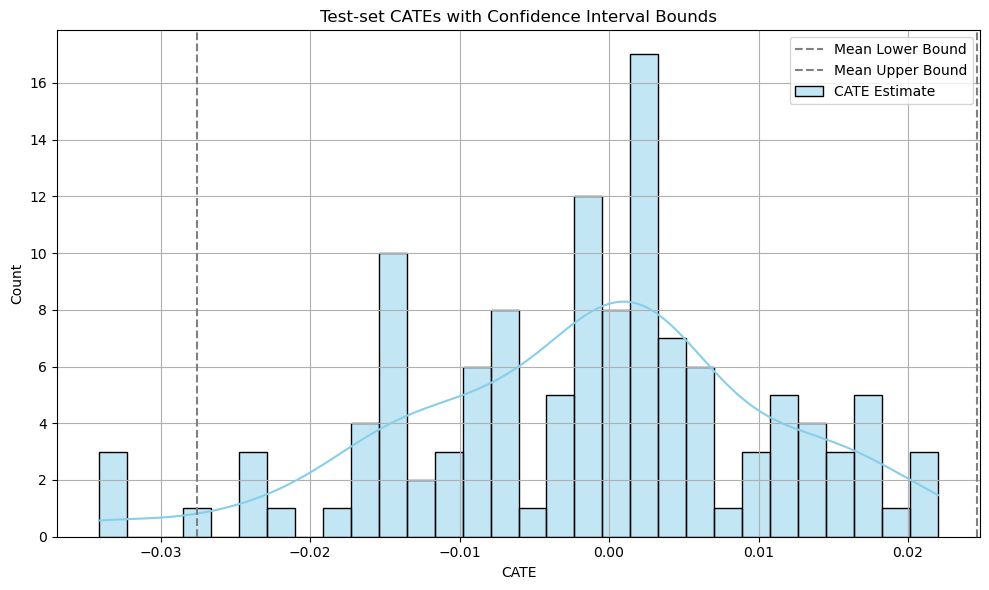

In [18]:
# 1.1 Confidence Intervals on CATE for Test Set
intervals_test = cf.effect_interval(X_test)
lower_bound, upper_bound = intervals_test

# 1.2 Add to test dataframe
df_model_test['CATE_lower'] = lower_bound
df_model_test['CATE_upper'] = upper_bound

# 1.3 Plot CATEs with Confidence Intervals
plt.figure(figsize=(10, 6))
sns.histplot(df_model_test['CATE'], bins=30, kde=True, color='skyblue', label='CATE Estimate')
plt.axvline(x=df_model_test['CATE_lower'].mean(), color='gray', linestyle='--', label='Mean Lower Bound')
plt.axvline(x=df_model_test['CATE_upper'].mean(), color='gray', linestyle='--', label='Mean Upper Bound')
plt.title("Test-set CATEs with Confidence Interval Bounds")
plt.xlabel("CATE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Predicted treatment effect (CATE) × actual treatment assignment
X_r = T_test.values.reshape(-1, 1) * cate_test.reshape(-1, 1)

# Fit a linear model to predict outcome Y using estimated treatment effects
lr = LinearRegression()
lr.fit(X_r, Y_test)

# Predict Y using this linear model
Y_pred = lr.predict(X_r)

# R² for how much of the outcome is explained by CATEs
r2 = r2_score(Y_test, Y_pred)
print(f"R² (Y ~ CATE * T): {r2:.4f}")


R² (Y ~ CATE * T): 0.0010


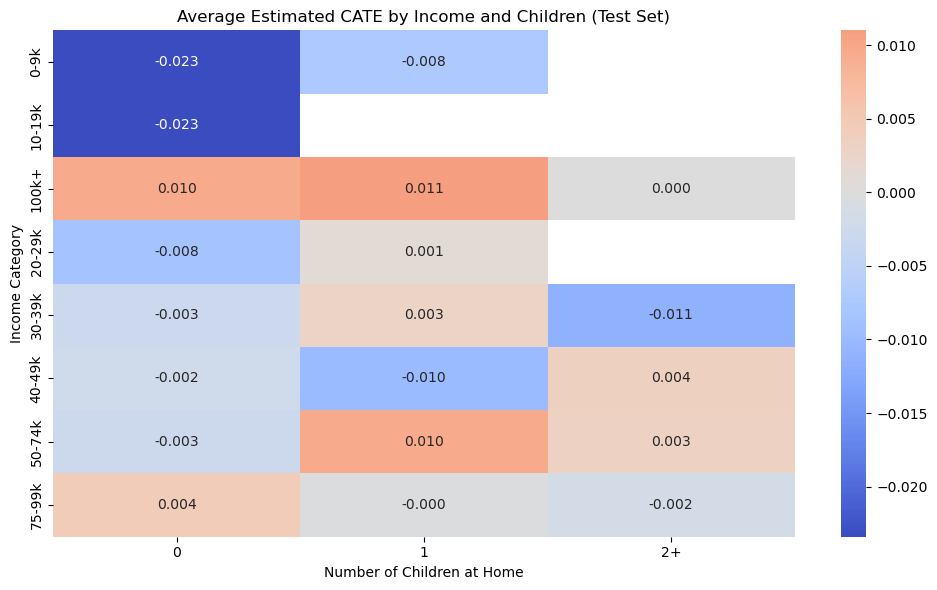

In [20]:
# 3.1 Map categorical labels back (optional for readability)
income_map = {
    0: '0-9k', 1: '10-19k', 2: '20-29k', 3: '30-39k',
    4: '40-49k', 5: '50-74k', 6: '75-99k', 7: '100k+'
}
children_map = {0: '0', 1: '1', 2: '2+'}

df_model_test['Income'] = df_model_test['INCOME_CATEGORY_num'].map(income_map)
df_model_test['Children'] = df_model_test['CHILDREN_AT_HOME_num'].map(children_map)

# 3.2 Grouped Summary
summary = df_model_test.groupby(['Income', 'Children'])['CATE'].agg(['mean', 'count']).reset_index()

# 3.3 Heatmap
pivot = df_model_test.pivot_table(index='Income', columns='Children', values='CATE', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='coolwarm', center=0)
plt.title("Average Estimated CATE by Income and Children (Test Set)")
plt.ylabel("Income Category")
plt.xlabel("Number of Children at Home")
plt.tight_layout()
plt.show()


# Complete Model

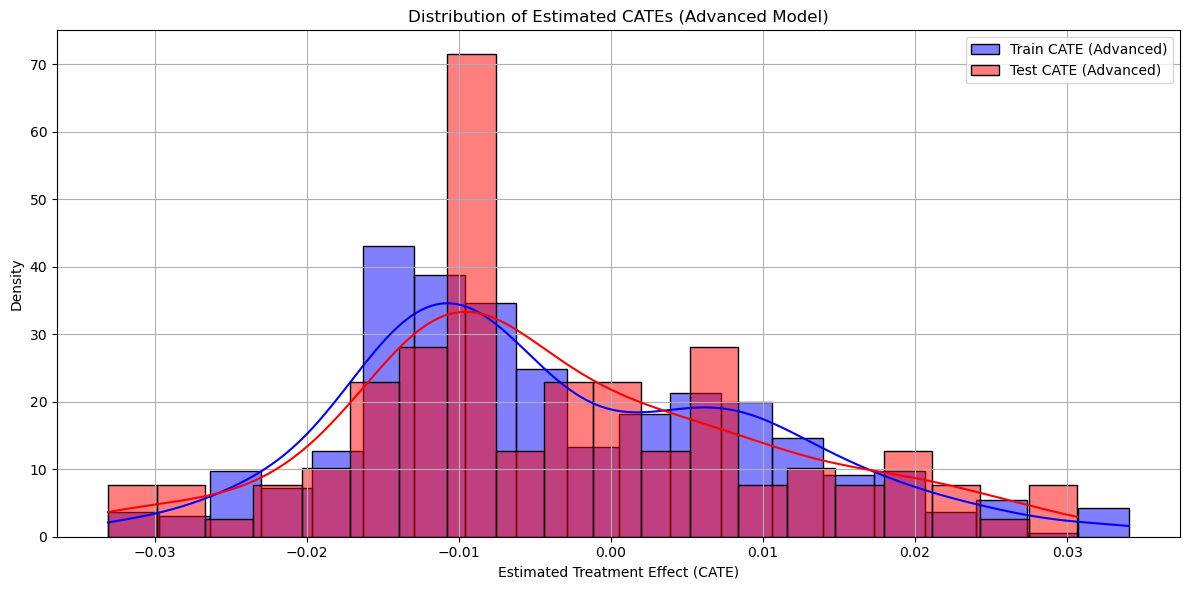

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
import seaborn as sns

# One-hot encode AGE_GROUP
df_model_encoded = pd.get_dummies(df_model, columns=['AGE_GROUP'], drop_first=True)
feature_cols_advanced = [
    'INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num', 'NUMBER_OF_BEDROOMS_num', 
    'HIGHEST_QUALIFICATION_num',  'SOCIAL_GRADE_num',
    'HOME_VALUE_num'
]

# Define features
#feature_cols_advanced = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']
age_cols = [col for col in df_model_encoded.columns if col.startswith('AGE_GROUP_')]
X_advanced = df_model_encoded[feature_cols_advanced + age_cols] 
T_advanced = df_model_encoded['Group']
Y_advanced = df_model_encoded['Delta']

# Split
X_train_adv, X_test_adv, T_train_adv, T_test_adv, Y_train_adv, Y_test_adv = train_test_split(
    X_advanced, T_advanced, Y_advanced, test_size=0.2, random_state=42
)

# Causal Forest setup
model_y_adv = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)
model_t_adv = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)

cf_advanced = CausalForestDML(
    model_y=model_y_adv,
    model_t=model_t_adv,
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    max_samples=0.5,
    discrete_treatment=True,
    cv=5,
    honest=True,
    criterion='mse',
    random_state=1
)

cf_advanced.fit(Y_train_adv, T_train_adv, X=X_train_adv)

# Estimate CATE
cate_train_adv = cf_advanced.effect(X_train_adv)
cate_test_adv = cf_advanced.effect(X_test_adv)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(cate_train_adv, color='blue', label='Train CATE (Advanced)', kde=True, stat="density", bins=20)
sns.histplot(cate_test_adv, color='red', label='Test CATE (Advanced)', kde=True, stat="density", bins=20)
plt.title("Distribution of Estimated CATEs (Advanced Model)")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


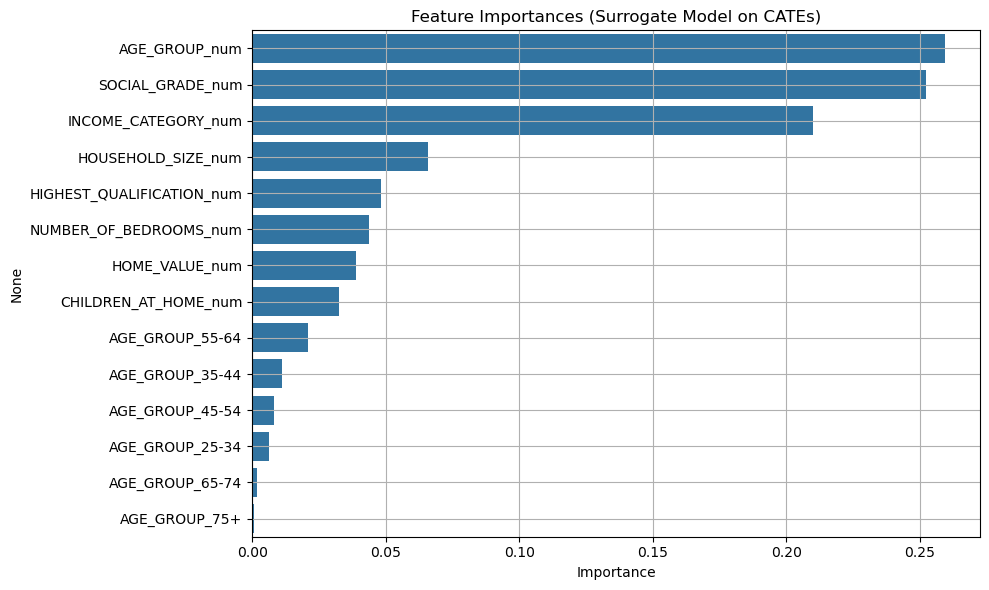

In [22]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Fit surrogate model
surrogate_model = RandomForestRegressor(random_state=42)
surrogate_model.fit(X_train_adv, cate_train_adv)

# Feature importances
importances = surrogate_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train_adv.columns).sort_values(ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importances (Surrogate Model on CATEs)")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict Y using τ̂(X) * T as proxy for treatment contribution
# This is not the same as full outcome prediction but helps understand explanatory power of τ̂
y_hat_test = cate_test_adv * T_test_adv
pseudo_rmse = np.sqrt(mean_squared_error(Y_test_adv, y_hat_test))
print(f"Pseudo RMSE (CATE × T vs. Y): {pseudo_rmse:.4f}")


Pseudo RMSE (CATE × T vs. Y): 0.0518


# Evaluation of models

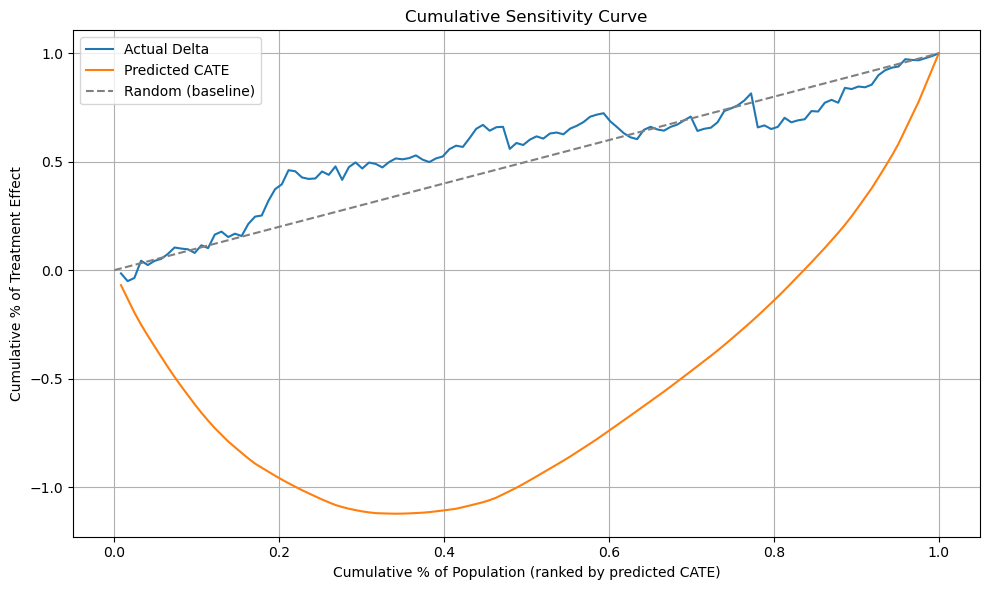

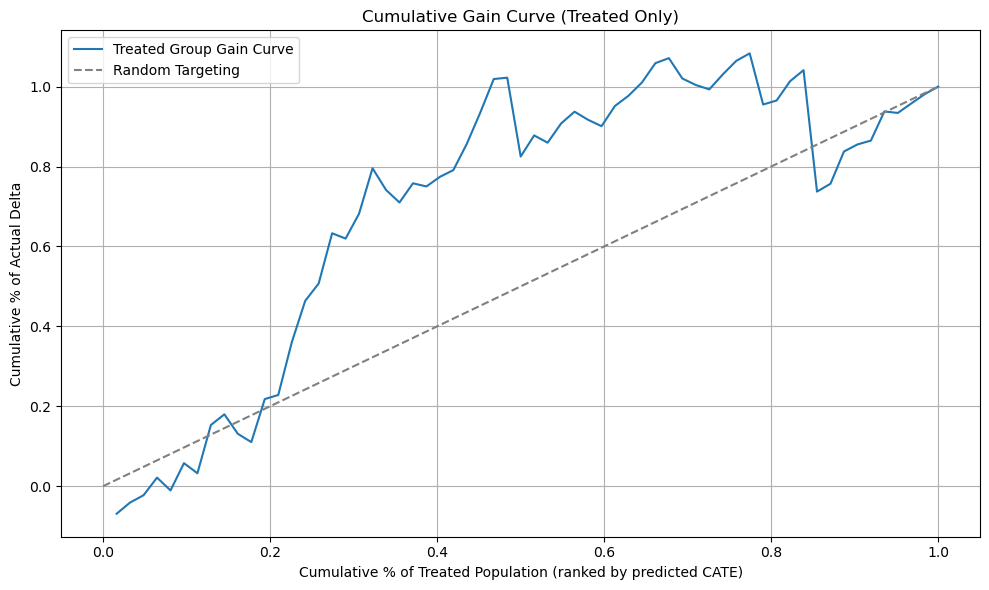

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Combine test set data
# -------------------------------------------
df_eval = X_test_adv.copy()
df_eval['CATE'] = cate_test_adv
df_eval['Delta'] = Y_test_adv
df_eval['Treatment'] = T_test_adv

# -------------------------------------------
# Sort by CATE (descending): households with strongest predicted effect first
# -------------------------------------------
df_sorted = df_eval.sort_values(by='CATE', ascending=False).reset_index(drop=True)
df_sorted['Cumulative_Count'] = np.arange(1, len(df_sorted)+1)

# -------------------------------------------
# Cumulative Sensitivity: sum of actual effects (Delta) across percentiles
# -------------------------------------------
df_sorted['Cumulative_Actual_Effect'] = df_sorted['Delta'].cumsum()
df_sorted['Cumulative_Predicted_Effect'] = df_sorted['CATE'].cumsum()

# Normalize by total sum to get % of effect captured
total_actual = df_sorted['Delta'].sum()
total_pred = df_sorted['CATE'].sum()
df_sorted['%_Actual_Effect'] = df_sorted['Cumulative_Actual_Effect'] / total_actual
df_sorted['%_Predicted_Effect'] = df_sorted['Cumulative_Predicted_Effect'] / total_pred
df_sorted['% Population'] = df_sorted['Cumulative_Count'] / len(df_sorted)

# -------------------------------------------
# PLOT: Cumulative Sensitivity Curve
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Population', y='%_Actual_Effect', data=df_sorted, label='Actual Delta')
sns.lineplot(x='% Population', y='%_Predicted_Effect', data=df_sorted, label='Predicted CATE')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random (baseline)')
plt.xlabel('Cumulative % of Population (ranked by predicted CATE)')
plt.ylabel('Cumulative % of Treatment Effect')
plt.title('Cumulative Sensitivity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------------------
# Cumulative Gain: uplift modeling performance
# -------------------------------------------
df_treated = df_sorted[df_sorted['Treatment'] == 1].copy()
df_control = df_sorted[df_sorted['Treatment'] == 0].copy()

# Rank by CATE in treated group
df_treated = df_treated.sort_values(by='CATE', ascending=False).reset_index(drop=True)
df_treated['Rank'] = np.arange(1, len(df_treated)+1)
df_treated['% Population'] = df_treated['Rank'] / len(df_treated)
df_treated['Cumulative Effect'] = df_treated['Delta'].cumsum()
df_treated['% Cumulative Effect'] = df_treated['Cumulative Effect'] / df_treated['Delta'].sum()

# -------------------------------------------
# PLOT: Cumulative Gain Curve
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Population', y='% Cumulative Effect', data=df_treated, label='Treated Group Gain Curve')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random Targeting')
plt.xlabel('Cumulative % of Treated Population (ranked by predicted CATE)')
plt.ylabel('Cumulative % of Actual Delta')
plt.title('Cumulative Gain Curve (Treated Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



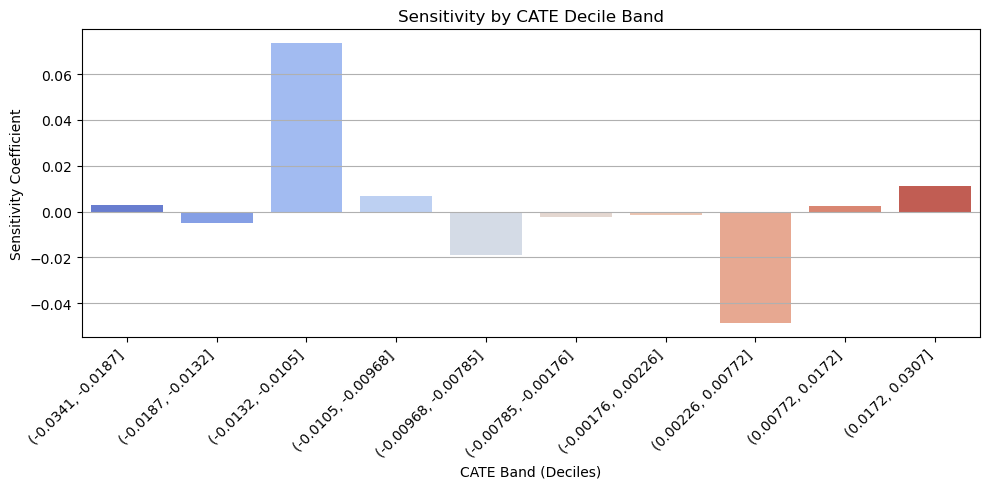

In [25]:
import pandas as pd
import numpy as np
from toolz import curry
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define Sensitivity Function
# -----------------------------
@curry
def sensitivity(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * (data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band": pd.qcut(df[pred], q=bands, duplicates='drop')})
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))
            .reset_index(name='Sensitivity'))

# -----------------------------
# 2. Prepare Data
# -----------------------------
df_sens = X_test_adv.copy()
df_sens['CATE'] = cate_test_adv
df_sens['Delta'] = Y_test_adv
df_sens['Treatment'] = T_test_adv

# -----------------------------
# 3. Compute Sensitivity by CATE Band
# -----------------------------
sensitivity_results = sensitivity_by_band(df_sens, pred='CATE', y='Delta', t='Treatment', bands=10)

# -----------------------------
# 4. Plot Sensitivity by CATE Band
# -----------------------------
plt.figure(figsize=(10, 5))
sns.barplot(data=sensitivity_results, x='CATE_band', y='Sensitivity', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Sensitivity by CATE Decile Band')
plt.ylabel('Sensitivity Coefficient')
plt.xlabel('CATE Band (Deciles)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [26]:
# ╭──────────────────────────────────────────────────────────────╮
# │   EVALUATION FUNCTIONS                                       │
# ╰──────────────────────────────────────────────────────────────╯

def cumulative_sensitivity(df, cate_col='CATE', outcome_col='Delta', treatment_col='Treatment'):
    # Sort by CATE descending (i.e., rank people from highest to lowest estimated effect)
    df_sorted = df.sort_values(by=cate_col, ascending=False).copy()
    
    # Initialize lists
    sens_list = []
    frac_list = []
    
    for i in range(1, len(df_sorted)+1):
        # Take top i rows
        sub_df = df_sorted.iloc[:i]
        # Compute sensitivity
        sens = sensitivity(sub_df, y=outcome_col, t=treatment_col)
        sens_list.append(sens)
        frac_list.append(i / len(df_sorted))
    
    return pd.DataFrame({'Fraction': frac_list, 'CumulativeSensitivity': sens_list})

def cumulative_gain(df, prediction='CATE', y='Delta', t='Group', min_periods=30, steps=100):
    size = df.shape[0]
    df_sorted = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # Avoid zero step size in range
    step_size = max(1, size // steps)
    n_rows = list(range(min_periods, size, step_size)) + [size]

    return np.array([
        sensitivity(df_sorted.head(rows), y=y, t=t) * (rows / size)
        for rows in n_rows
    ])


def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1 * df[t])
    se = np.sqrt(((1 / (n - 2)) * np.sum(e**2)) / np.sum((df[t] - t_bar)**2))
    return np.array([beta1 - z * se, beta1 + z * se])  # ✅ fixed `see` → `se`


def cumulative_sensitivity_curve_ci(df, prediction='CATE', y='Delta', t='Group', min_periods=30, steps=100):
    size = df.shape[0]
    df_sorted = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    step_size = max(1, size // steps)
    n_rows = list(range(min_periods, size, step_size)) + [size]

    return np.array([
        sensitivity_ci(df_sorted.head(rows), y=y, t=t)
        for rows in n_rows
    ])




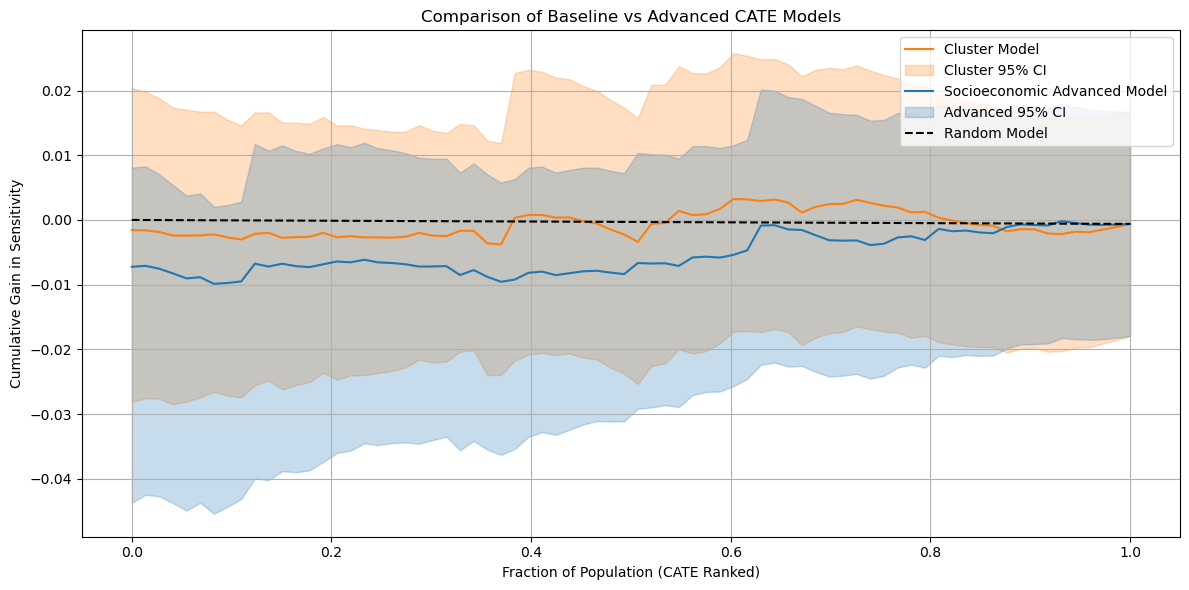

In [27]:
# 1 Create models

# Create baseline test set (if not already)
df_model_test_base = X_test.copy()
df_model_test_base['Group'] = T_test
df_model_test_base['Delta'] = Y_test
df_model_test_base['CATE'] = cate_test  # <- from the baseline model


# Create advanced test set
df_model_test = X_test_adv.copy()
df_model_test['Group'] = T_test_adv
df_model_test['Delta'] = Y_test_adv
df_model_test['CATE'] = cate_test_adv

import numpy as np
import matplotlib.pyplot as plt

# 1. Compute cumulative gain for both models
cum_gain_base = cumulative_gain(df_model_test_base, "CATE", "Delta", "Group", min_periods=50, steps=200)
cum_gain_adv = cumulative_gain(df_model_test, "CATE", "Delta", "Group", min_periods=50, steps=200)

# 2. Compute confidence intervals
cum_gain_ci_base = cumulative_sensitivity_curve_ci(df_model_test_base, "CATE", "Delta", "Group", min_periods=50, steps=200)
cum_gain_ci_adv = cumulative_sensitivity_curve_ci(df_model_test, "CATE", "Delta", "Group", min_periods=50, steps=200)

# 3. Define x-axis (normalized rank)
x_vals = np.linspace(0, 1, len(cum_gain_base))

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(x_vals, cum_gain_base, label="Cluster Model", color="C1")
plt.fill_between(x_vals, cum_gain_ci_base[:, 0], cum_gain_ci_base[:, 1], alpha=0.25, color="C1", label="Cluster 95% CI")

plt.plot(x_vals, cum_gain_adv, label="Socioeconomic Advanced Model", color="C0")
plt.fill_between(x_vals, cum_gain_ci_adv[:, 0], cum_gain_ci_adv[:, 1], alpha=0.25, color="C0", label="Advanced 95% CI")

# Reference line
baseline_sens = sensitivity(df_model_test_base, y='Delta', t='Group')
plt.plot([0, 1], [0, baseline_sens], linestyle='--', color='black', label='Random Model')

# Formatting
plt.xlabel("Fraction of Population (CATE Ranked)")
plt.ylabel("Cumulative Gain in Sensitivity")
plt.title("Comparison of Baseline vs Advanced CATE Models")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Comparison of Cluster-Only vs Socioeconomic Advanced CATE Models

The plot above displays cumulative gain in sensitivity for two CATE models:
- **Cluster Model (orange)**: This baseline model uses only the counterfactual clusters (derived from energy usage profiles) as features.
- **Socioeconomic Advanced Model (blue)**: This model incorporates selected socioeconomic variables—`INCOME_CATEGORY`, `CHILDREN_AT_HOME`, and others—chosen for their relevance to behavioral energy consumption.

#### Interpretation:

- **Cumulative Gain Curve**: Measures how well the model identifies individuals for whom the treatment (intervention) had the largest effect on consumption. Higher cumulative gain suggests better ranking of treatment effect heterogeneity.
- **Confidence Bands (95%)**: Indicate uncertainty around each model's gain estimate at different fractions of the population.

#### Key Observations:

- The **Cluster Model** shows a slightly higher cumulative gain than the socioeconomic model across most of the population, suggesting that usage-based clusters alone offer meaningful structure for targeting.
- The **Socioeconomic Model** exhibits more stability in the gain curve and less deviation from the random baseline, which may reflect a more conservative ranking of treatment effect heterogeneity.
- Both models outperform the **Random Model** baseline (dashed line), meaning they are learning signal beyond noise.

#### Conclusion:

The cluster-only model provides slightly better targeting performance in terms of treatment effect sensitivity, though its confidence interval overlaps significantly with the socioeconomic model. The socioeconomic model may offer better interpretability and fairness. Depending on program goals (e.g., targeting vs understanding), either could be preferable. Future work could explore **hybrid models** that combine both sets of features for improved performance.


invalid value encountered in scalar divide


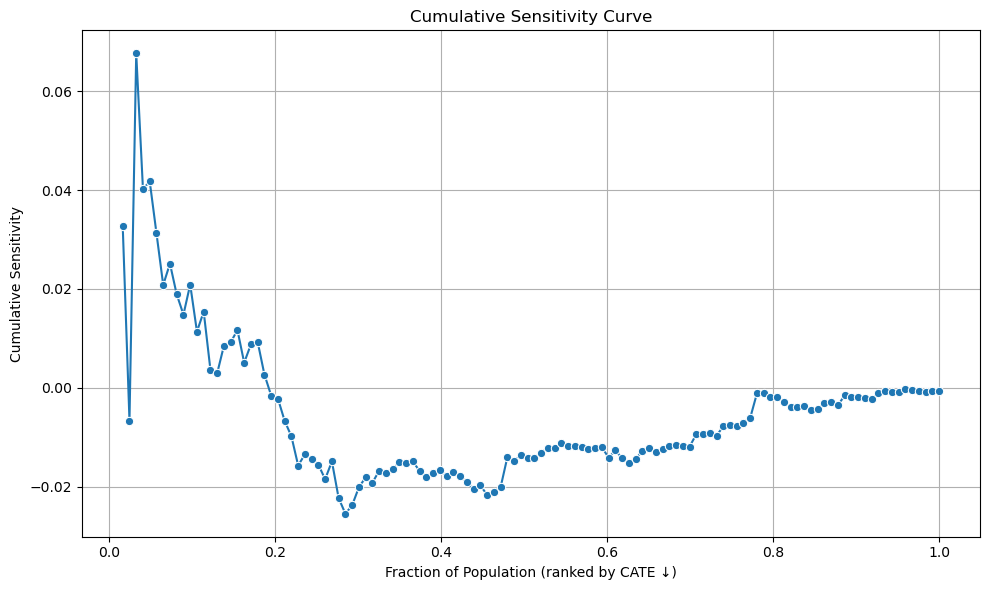

In [28]:
# Compute and Plot
cum_sens_df = cumulative_sensitivity(df_sens, cate_col='CATE', outcome_col='Delta', treatment_col='Treatment')

plt.figure(figsize=(10, 6))
sns.lineplot(data=cum_sens_df, x='Fraction', y='CumulativeSensitivity', marker='o')
plt.title("Cumulative Sensitivity Curve")
plt.xlabel("Fraction of Population (ranked by CATE ↓)")
plt.ylabel("Cumulative Sensitivity")
plt.grid(True)
plt.tight_layout()
plt.show()


R Learner

📊 R-Learner Pseudo RMSE: 0.0504


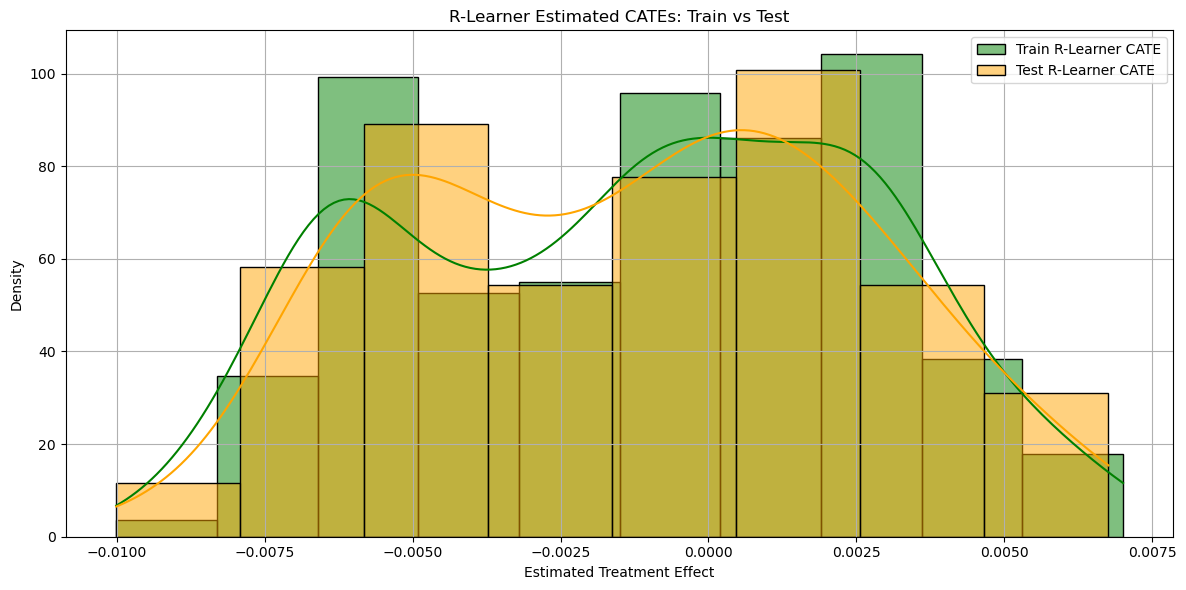

In [29]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define Features and Split
features = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']  # Add more if needed
X = df_model[features]
T = df_model['Group']
Y = df_model['Delta']

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

# 2. Instantiate and Fit R-Learner using LinearDML
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

rlearner = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, random_state=42)
rlearner.fit(Y_train, T_train, X=X_train)

# 3. Predict CATE
cate_r_train = rlearner.effect(X_train)
cate_r_test = rlearner.effect(X_test)

# 4. Pseudo RMSE as diagnostic
rms_rlearner = np.sqrt(np.mean((T_test * cate_r_test - Y_test) ** 2))
print(f"📊 R-Learner Pseudo RMSE: {rms_rlearner:.4f}")

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.histplot(cate_r_train, color='green', label='Train R-Learner CATE', kde=True, stat="density")
sns.histplot(cate_r_test, color='orange', label='Test R-Learner CATE', kde=True, stat="density")
plt.title("R-Learner Estimated CATEs: Train vs Test")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
df_model_test['CATE'] = cate_test
grouped = df_model_test.groupby('Cluster')['CATE'].agg(['mean', 'std', 'count'])
print(grouped.sort_values('mean'))


KeyError: 'Cluster'

In [ ]:
sns.barplot(data=df_model_test, x='INCOME_CATEGORY_num', y='CATE')
sns.barplot(data=df_model_test, x='CHILDREN_AT_HOME_num', y='CATE')


# FIXED EFFECTS

In [50]:
import pandas as pd

# 1. Merge the static socio-economic info (optional; FE will absorb most of it)
df = df_peak_merged.merge(
        socio_df[['ANON_ID', 'AGE_GROUP_num', 'INCOME_CATEGORY_num']],  # keep only time-varying or needed vars
        how='left', on='ANON_ID'
     )

# 0. Inspect the dtype
print(df['Date'].dtype)          # very likely 'object'

# 1. Make it true datetime (or numeric if you prefer)
df['Date'] = pd.to_datetime(df['Date'])      # <- the critical line
#   If you only have month / year info:
#   df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')




# 2. Create a DID-style interaction that actually varies within households
df['treat_post'] = df['Treatment'] * df['Post']     # 1 only for treated HHs *after* the intervention

# 3. Set a panel index (household, date)
df = df.set_index(['ANON_ID', 'Date']).sort_index()


object


In [51]:
import statsmodels.formula.api as smf

df_reset = df.reset_index()        # statsmodels likes a flat DF
model = smf.ols(
    'peak_kwh ~ Post + treat_post + Temp_4to7_avg + C(ANON_ID) + C(Date)',
    data=df_reset
).fit(cov_type='cluster', cov_kwds={'groups': df_reset['ANON_ID']})

print(model.summary())




covariance of constraints does not have full rank. The number of constraints is 1217, but rank is 2
invalid value encountered in sqrt


                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                 5.710e-09
Date:                Tue, 20 May 2025   Prob (F-statistic):               1.00
Time:                        12:20:22   Log-Likelihood:             1.3462e+05
No. Observations:              345196   AIC:                        -2.668e+05
Df Residuals:                  343980   BIC:                        -2.537e+05
Df Model:                        1215                                         
Covariance Type:              cluster                                         
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

In [52]:
# Pull point estimate, SE, t-stat and p-value
coef_table = (
    model
      .summary2()
      .tables[1]                       # coefficient table
      .loc[['treat_post']]             # or .filter(like='treat_post')
)

print(coef_table)


               Coef.  Std.Err.   z  P>|z|  [0.025  0.975]
treat_post -0.005166       NaN NaN    NaN     NaN     NaN
